In [1]:
import pandas as pd
import requests
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
import time
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')
sns.set(style='whitegrid',palette='pastel')
from pylab import rcParams
matplotlib.rcParams['pdf.fonttype'] = 42

%matplotlib inline

[nltk_data] Downloading package punkt to /Users/lilyliu-
[nltk_data]     krason/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lilyliu-
[nltk_data]     krason/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !pip install nltk

# Import and Do More Cleaning

In [3]:
df=pd.read_csv('merged_final_10122019.csv',thousands=',')

In [4]:
df=df.drop(columns=['raised','goal'])

In [5]:
df.head(3)

Unnamed: 0                                               link  \
0           0  https://www.gofundme.com/steven-crowder-live-a...   
1           1  https://www.gofundme.com/reopen-a-nc-republica...   
2           2            https://www.gofundme.com/troopersanchez   

        location                               title       created_date  \
0     Dallas, TX         Steven Crowder Live at SMU!      March 7, 2018   
1  Brookline, MA  Dems help reopen a NC Repub office   October 16, 2016   
2    Mcallen, TX    Funds for Trooper Moises Sanchez      April 7, 2019   

                                             summary  tag state  goal_int  \
0  SMU College Republicans is bringing comedian S...  rep    TX    6500.0   
1  NOTE: We reached our goal and then some in les...  rep    MA   10000.0   
2  ￼Moises Sanchez, a Texas State Trooper, was sh...  rep    TX   20000.0   

   raised_int  
0      2710.0  
1     12857.0  
2     13171.0

In [6]:
#getting a look at how many campaigns with word "democrat" vs "republican"
df.tag.value_counts()

rep    865
dem    845
Name: tag, dtype: int64

In [7]:
#overlap count
df.link.value_counts()[df.link.value_counts()==2].count()

247

In [8]:
#converting dates
df['created_date']=df.created_date.str.replace('Created ','')

# df['date']=pd.to_datetime(df.created_date,infer_datetime_format=True)

In [9]:
#you'll have to drop the 1 day ago, 3 days ago...
ago_df=df[df.created_date.str.contains('ago')==True]
ago_df['created_date']=ago_df.created_date.str.replace(' ago','')

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
ago_df.head(3)

Unnamed: 0                                               link  \
41           45  https://www.gofundme.com/send-a-message-to-was...   
54           61        https://www.gofundme.com/republican-support   
195         240  https://www.gofundme.com/support-pres-trump-ma...   

             location                                          title  \
41        Melrose, MA                   TO ALL REPUBLICANS IN OFFICE   
54     Plantation, FL                             Republican Support   
195  Saint George, UT  Support Pres. Trump MAGA Rally in St. George!   

    created_date                                            summary  tag  \
41         1 day  Let's send a message to Moscow Mitch and all t...  rep   
54        7 days            I’m trying to Make America Great Again.  rep   
195       2 days  Help us cover the expenses of our Rally to sup...  rep   

    state  goal_int  raised_int  
41     MA   35000.0       100.0  
54     FL   10000.0         0.0  
195    UT    2020.0       455.0

In [11]:
# turn hours ago to 1 day ago
ago_df.loc[ago_df.created_date.str.contains("hour"), 'created_date']='1 day'

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
# extract the date difference
ago_df['data_diff'] = ago_df.created_date.str.extract(r'(\d+)', expand=False).astype(int)

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
#since this data was grabbed 7/17 we'll have to subtract a few more days
ago_df['created_actual']=ago_df['data_diff'].apply(lambda x: pd.datetime.now().date()-timedelta(days=x+20))

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
ago_df=ago_df.drop(columns=['created_date','data_diff'])

In [15]:
ago_df=ago_df.rename(columns={'created_actual':'created_date'})

In [16]:
df=df[df.created_date.str.contains('ago')==False]

In [17]:
df=df.append(ago_df)

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [18]:
#convert to datetime and add Year, Month, Weekday
df['year']=pd.to_datetime(df.created_date).dt.year
df['month']=pd.to_datetime(df.created_date).dt.month
df['weekday_name'] =pd.to_datetime(df.created_date).dt.weekday_name

In [19]:
# df.to_csv('cleaned_10122019.csv',index=False)

# Using Crosstab to Compare "Democrat" vs "Republican"

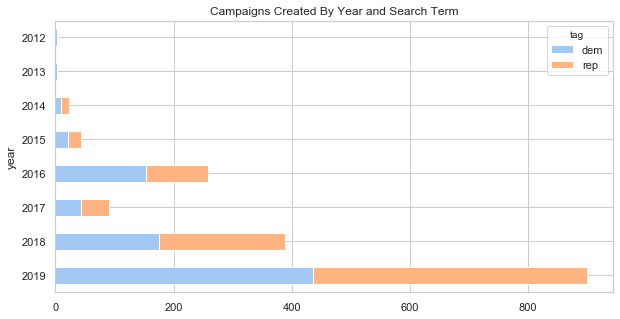

In [20]:
pd.crosstab(index=df.year,columns=df.tag).sort_values(by='year',ascending=False).plot(kind='barh',stacked=True,title='Campaigns Created By Year and Search Term',figsize=(10,5))
# plt.savefig("total_campaigns_by_year.pdf")

In [21]:
overlap=df[df.link.isin(df.link.value_counts()[df.link.value_counts()==2].index)]

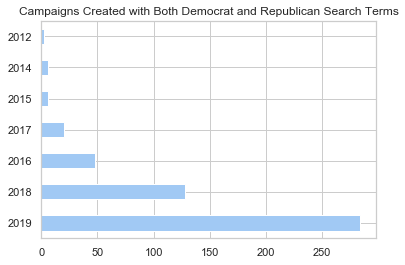

In [22]:
overlap.year.value_counts().plot(kind='barh',title='Campaigns Created with Both Democrat and Republican Search Terms')
plt.savefig("overlap.pdf")

In [23]:
df.year.unique()

array([2018, 2016, 2019, 2015, 2017, 2014, 2012, 2013])

In [24]:
for c in df.year.sort_values().unique():
    print(c)
    year_df=df[df['year']==int(f'{c}')]
    print(year_df[['month','tag']].groupby('tag').month.value_counts())

2012
tag  month
dem  1        1
     8        1
     11       1
rep  8        1
     11       1
Name: month, dtype: int64
2013
tag  month
dem  4        1
     6        1
Name: month, dtype: int64
2014
tag  month
dem  9        3
     4        2
     12       2
     1        1
     8        1
     11       1
rep  12       4
     6        3
     11       2
     2        1
     3        1
     4        1
     8        1
Name: month, dtype: int64
2015
tag  month
dem  5        4
     6        3
     12       3
     1        2
     3        2
     4        2
     9        2
     11       2
     8        1
rep  2        4
     12       4
     5        3
     10       3
     8        2
     9        2
     11       2
     4        1
     6        1
     7        1
Name: month, dtype: int64
2016
tag  month
dem  6        63
     5        35
     4        12
     7         9
     1         5
     3         5
     8         5
     9         5
     10        5
     12        4
     11        3
     

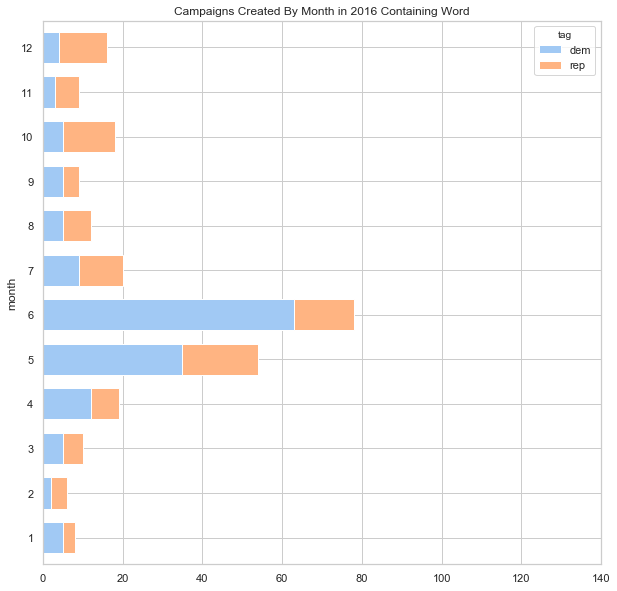

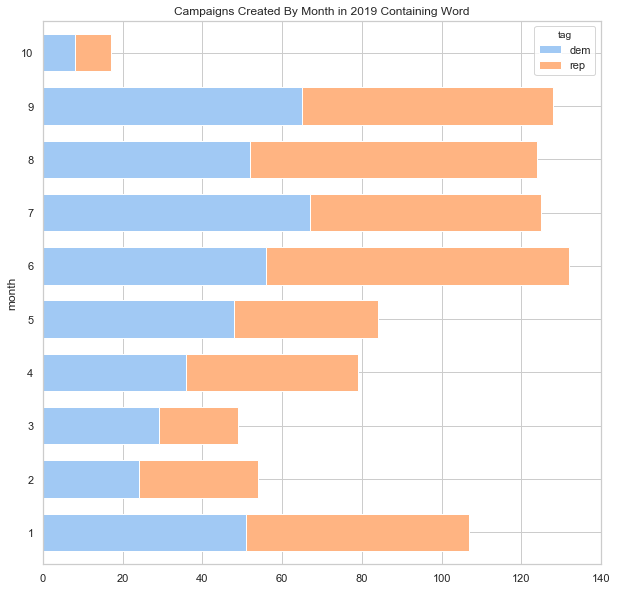

In [25]:
rcParams['figure.figsize'] = 20, 2

for c in [2016,2019]:
#     plt.figure()
    year_df=df[df['year']==int(f'{c}')]
    pd.crosstab(index=year_df.month,columns=year_df.tag).plot(kind='barh',stacked=True,width=0.7,title='Campaigns Created By Month in '+ f'{c}' + ' Containing Word',figsize=(10,10))
    plt.xticks(range(0,150,20))

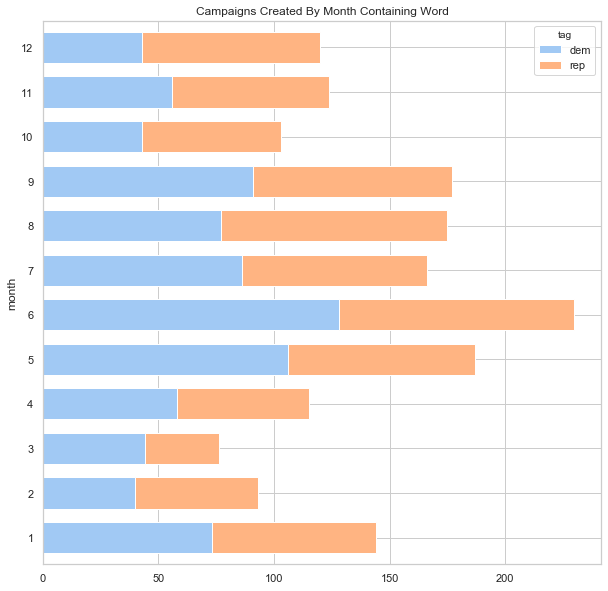

In [26]:
pd.crosstab(index=df.month,columns=df.tag).plot(kind='barh',stacked=True,width=0.7,title='Campaigns Created By Month Containing Word',figsize=(10,10))

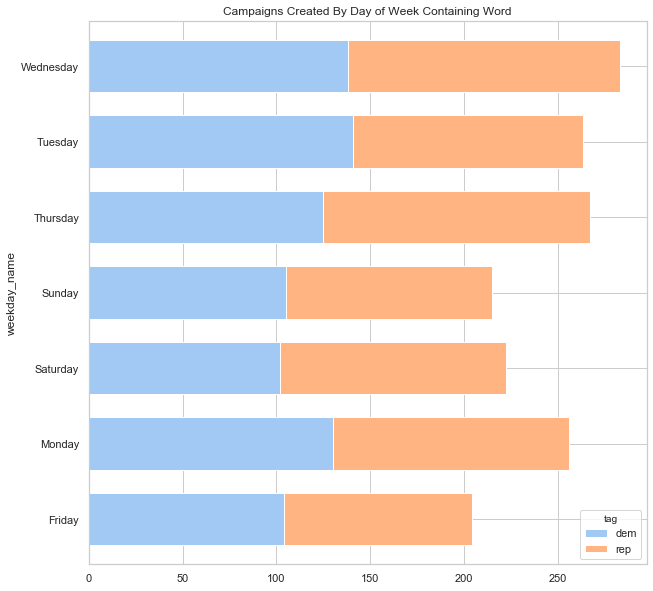

In [27]:
pd.crosstab(index=df['weekday_name'],columns=df.tag).plot(kind='barh',stacked=True,width=0.7,title='Campaigns Created By Day of Week Containing Word',figsize=(10,10))

In [28]:
df.groupby('tag')['goal_int'].median()

tag
dem     5000.0
rep    10000.0
Name: goal_int, dtype: float64

In [29]:
overlap.goal_int.median()

10000.0

In [30]:
# plt.figure(figsize=(10,10))
# sns.catplot(x='year',y='goal_int',hue='tag',data=df,palette='Purples')
# plt.yticks(range(0,1000000000), step=500)
# plt.ticklabel_format(style='plain', axis='y',useOffset=False)

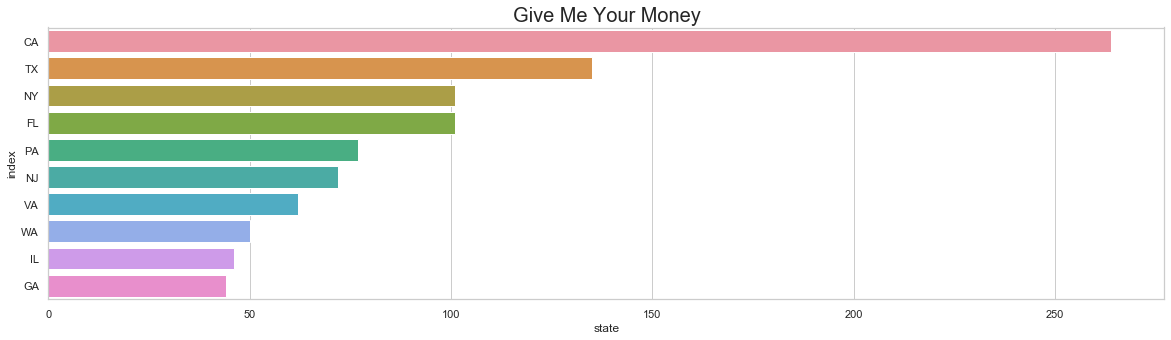

In [31]:
plt.figure(figsize=(20,5))
sns.set(style='whitegrid',palette='husl')
sns.barplot(y='index',x='state',data=df.state.value_counts().sort_values(ascending=False).head(10).reset_index())
plt.title('Give Me Your Money',{'fontsize': 20,'fontweight' : 1})
plt.savefig("campaigns_by_state.pdf")

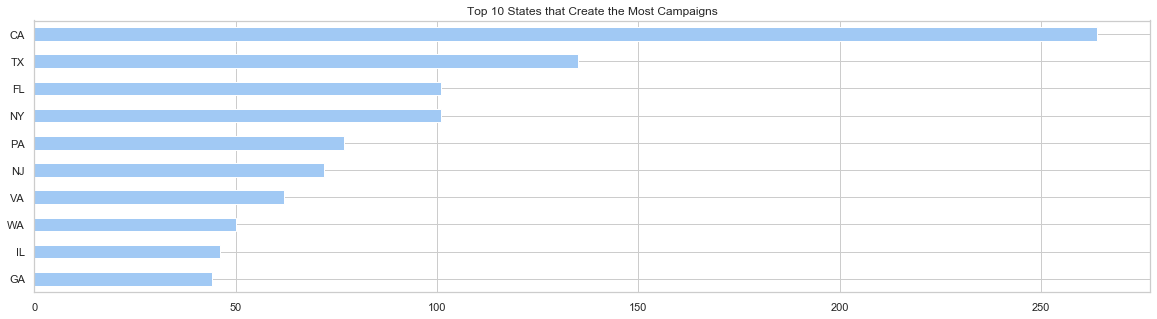

In [32]:
sns.set(style='whitegrid',palette='pastel')
df.state.value_counts().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind='barh',figsize=(20,5),title='Top 10 States that Create the Most Campaigns')


In [33]:
df.columns

Index(['Unnamed: 0', 'created_date', 'goal_int', 'link', 'location',
       'raised_int', 'state', 'summary', 'tag', 'title', 'year', 'month',
       'weekday_name'],
      dtype='object')

In [34]:
df.sort_values(by='raised_int',ascending=False).drop_duplicates(['created_date', 'goal_int', 'link', 'location',
       'raised_int', 'state', 'summary', 'title', 'year', 'month',
       'weekday_name']).groupby('state').raised_int.sum().reset_index().sort_values(by='raised_int',ascending=False).head(10)

state  raised_int
9     FL  25256477.0
4     CA    851952.0
7     DC    750296.0
27    NC    562446.0
34    NY    297800.0
47    WA    166127.0
10    GA    163693.0
43    TX    150005.0
31    NJ    110510.0
38    PA    108529.0

In [48]:
state_sum=df.drop_duplicates(['created_date', 'goal_int', 'link', 'location','raised_int', 'state', 'summary', 'title', 'year', 'month','weekday_name'])
state_sum=state_sum.groupby('state').raised_int.sum().sort_values(ascending=False).reset_index()
state_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
state         51 non-null object
raised_int    51 non-null float64
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes


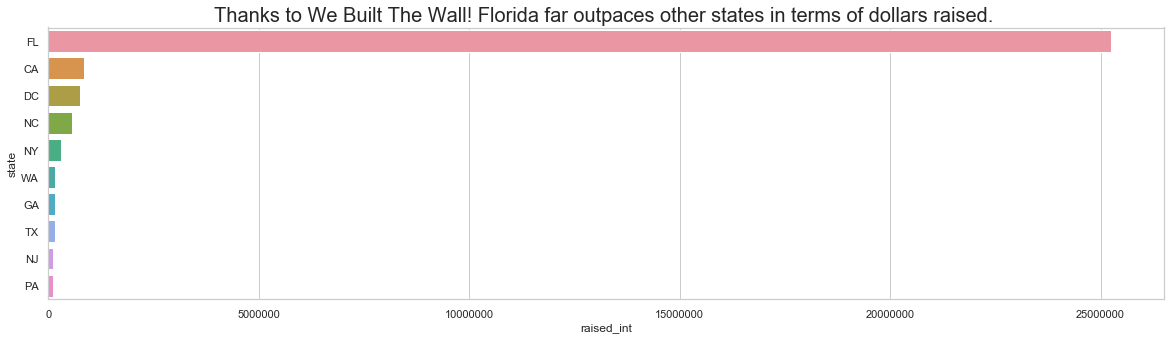

In [54]:

plt.figure(figsize=(20,5))
sns.set(style='whitegrid',palette='husl')

sns.barplot(x='raised_int',y='state',ci=0,data=state_sum.head(10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.title('Thanks to We Built The Wall! Florida far outpaces other states in terms of dollars raised. ',{'fontsize': 20,'fontweight' : 1})
plt.savefig("campaign_state_dollars.pdf")

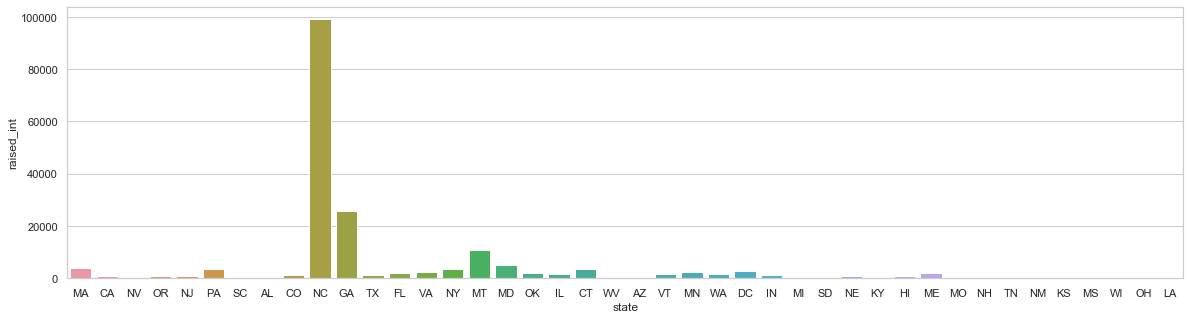

In [37]:
plt.figure(figsize=(20,5))
sns.barplot(x='state',y='raised_int',ci=0,data=overlap)

In [40]:
overlap.sort_values(by='raised_int',ascending=False)

Unnamed: 0         created_date    goal_int  \
180          224   September 24, 2018    600000.0   
954          127   September 24, 2018    600000.0   
182          226    December 19, 2014    150000.0   
957          130    December 19, 2014    150000.0   
974          148         May 31, 2018     36000.0   
200          245         May 31, 2018     36000.0   
192          237     February 2, 2017     35000.0   
965          138     February 2, 2017     35000.0   
214          260        June 24, 2016     50000.0   
996          174        June 24, 2016     50000.0   
961          134         May 10, 2018     25000.0   
188          232         May 10, 2018     25000.0   
232          279     January 21, 2018     15000.0   
1009         188     January 21, 2018     15000.0   
219          266    February 28, 2017     15000.0   
1002         180    February 28, 2017     15000.0   
981          156    February 16, 2019     15000.0   
203          249    February 16, 2019     15000.0   
964          137     October 16, 2016     10000.0   
1              1     October 16, 2016     10000.0   
986          164    November 28, 2017    100000.0   
210          256    November 28, 2017    100000.0   
977          151        July 21, 2019     16000.0   
201          246        July 21, 2019     16000.0   
193          238         July 3, 2019    100000.0   
966          139         July 3, 2019    100000.0   
330          380         May 17, 2016     15000.0   
1110         299         May 17, 2016     15000.0   
314          362    February 20, 2019     25000.0   
1087         272    February 20, 2019     25000.0   
...          ...                  ...         ...   
849          981         June 5, 2019   2000000.0   
852          985         June 3, 2019     10000.0   
855          988         May 31, 2019     10000.0   
856          990         May 31, 2019   5000000.0   
858          992         June 5, 2019    388000.0   
860          995         May 27, 2019     10000.0   
862          997         May 24, 2019     10000.0   
863          998         May 24, 2019      1000.0   
903           53     November 6, 2018     20000.0   
920           75        June 11, 2019    150000.0   
836          965        June 19, 2019     20000.0   
829          957        June 26, 2019  10000000.0   
777          889       August 6, 2019      5000.0   
825          953        June 27, 2019     10000.0   
778          890       August 8, 2019      5000.0   
782          894       August 5, 2019    100000.0   
784          897       August 4, 2019    100000.0   
786          899       August 1, 2019    100000.0   
788          901        July 31, 2019      2500.0   
794          908        July 27, 2019         1.0   
799          915        July 23, 2019       999.0   
806          925        July 18, 2019       500.0   
812          934        July 13, 2019      5000.0   
813          935        July 13, 2019    100000.0   
816          938         July 7, 2019      1000.0   
818          944         July 1, 2019      1000.0   
820          947        June 29, 2019   5000000.0   
821          949        June 29, 2019     50000.0   
824          952        June 28, 2019   1000000.0   
1543         796           2019-09-17     10000.0   

                                                   link  \
180    https://www.gofundme.com/support-brett-kavanaugh   
954    https://www.gofundme.com/support-brett-kavanaugh   
182           https://www.gofundme.com/DonSiegelmanFilm   
957           https://www.gofundme.com/DonSiegelmanFilm   
974              https://www.gofundme.com/sutton-strong   
200              https://www.gofundme.com/sutton-strong   
192            https://www.gofundme.com/CleaningGOPMess   
965            https://www.gofundme.com/CleaningGOPMess   
214                   https://www.gofundme.com/2b2twszf   
996                   https://www.gofundme.com/2b2twszf   
961            https://www.gofundme.com/theblekicfamily   
188        

# Aggregate Graphs


In [249]:
# #using seaborn time series formatting
# sns.set(rc={'figure.figsize':(11, 4)})

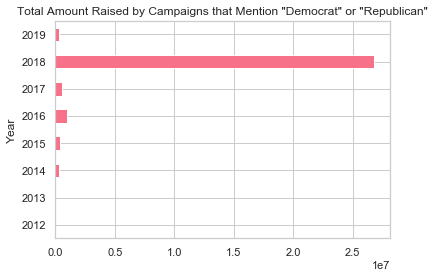

In [253]:
#total amount raised
#what is this scale though? How do I change this?
df.groupby('Year')['raised_int'].sum().plot(kind='barh',title='Total Amount Raised by Campaigns that Mention "Democrat" or "Republican"')

# plt.savefig("total_amount_raised.pdf")

In [254]:
data=pd.DataFrame(df.groupby('Year')['tag'].value_counts())

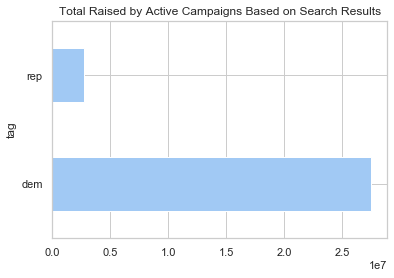

In [42]:
df.groupby('tag')['raised_int'].sum().plot(kind='barh',title='Total Raised by Active Campaigns Based on Search Results')

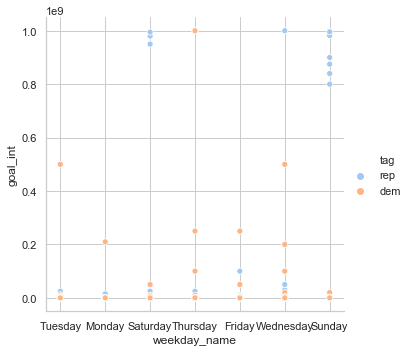

In [43]:
#the graveyard

graveyard = df[df['raised_int']==0]
sns.relplot(data=graveyard, x='weekday_name', y='goal_int', hue='tag')

In [49]:
graveyard[graveyard['weekday_name']=='Sunday'].sort_values(by='goal_int',ascending=False)

Unnamed: 0        created_date     goal_int  \
114          132   December 30, 2018  998000000.0   
115          133   December 30, 2018  996000000.0   
110          128   December 30, 2018  987000000.0   
112          130   December 30, 2018  982000000.0   
111          129   December 30, 2018  900000000.0   
113          131   December 30, 2018  875000000.0   
109          127   December 30, 2018  840000000.0   
116          134   December 30, 2018  800000000.0   
1684         960      April 21, 2019   20000000.0   
1594         848        July 7, 2019    5000000.0   
1685         961      April 21, 2019    3000000.0   
837          968      April 21, 2019    3000000.0   
945          112    October 14, 2018    1200000.0   
76            88      April 21, 2019     750000.0   
1635         895        June 9, 2019     500000.0   
60            68       June 23, 2019     500000.0   
846          978      April 14, 2019     250000.0   
1695         973      April 14, 2019     250000.0   
927           87    January 27, 2019     150000.0   
752          859          2019-07-14     100000.0   
759          871       June 30, 2019     100000.0   
1605         861       June 30, 2019     100000.0   
147          181    October 14, 2018     100000.0   
773          888       June 23, 2019      68000.0   
1556         809     October 7, 2018      50000.0   
712          813     October 7, 2018      50000.0   
859          994       June 16, 2019      30000.0   
129          157   November 25, 2018      20000.0   
1584         838       July 14, 2019      20000.0   
809          934        May 19, 2019      15000.0   
847          979      April 14, 2019      10000.0   
947          114     October 7, 2018      10000.0   
1606         862       June 30, 2019      10000.0   
1705         986       April 7, 2019      10000.0   
149          183     October 7, 2018      10000.0   
81            94      April 14, 2019      10000.0   
80            92      April 14, 2019       8000.0   
735          838  September 16, 2018       6000.0   
1696         974      April 14, 2019       5000.0   
940          105      April 21, 2019       5000.0   
132          161   November 18, 2018       5000.0   
1666         937        May 12, 2019       5000.0   
734          837  September 30, 2018       5000.0   
1704         985       April 7, 2019       4900.0   
858          993      March 31, 2019       3000.0   
1652         920        May 26, 2019       3000.0   
68            78        May 26, 2019       3000.0   
53            60       June 30, 2019       2000.0   
1585         839       July 14, 2019       2000.0   
760          873       June 30, 2019       2000.0   
750          857       July 14, 2019       2000.0   
1625         885       June 16, 2019       1500.0   
1589         843          2019-07-14       1200.0   
1595         849        July 7, 2019       1000.0   
54            61       June 30, 2019       1000.0   
1694         972      April 14, 2019       1000.0   
755          863        July 7, 2019       1000.0   
94           107   February 10, 2019        725.0   
729          831    October 21, 2018        500.0   
163          198     August 12, 2018        500.0   

                                                   link  \
114   https://www.gofundme.com/FundToProtectPresiden...   
115   https://www.gofundme.com/FundToSupportPresiden...   
110   https://www.gofundme.com/RepublicanFundraiserT...   
112   https://www.gofundme.com/RepublicanFundraiserA...   
111   https://www.gofundme.com/RepublicanFundraiserT...   
113   https://www.gofundme.com/FundToProtectPresiden...   
109   https://www.gofundme.com/RepublicanFundraiserT...   
116   https://www.gofundme.com/FundFor2020Republican...   
1684       https://www.gofundme.com/92gtc-support-trump   
1594                https://www.gofundme.com/1otubio4uo   
1685                https://www.gofundme.com/1m531qscpc   
837                 https://www.gofundme.com/1m531qscpc   
945  

# Common Words!

In [55]:
df=pd.read_csv('cleaned_10122019.csv')

In [147]:
#campaigns with search result for Republican
top_N = 100000
rep_rslt =pd.DataFrame()
for index, row in df[df['tag']=='rep'].iterrows():
    txt = row['summary'].lower()
    words = nltk.tokenize.word_tokenize(txt)
    word_dist = nltk.FreqDist(words)
    stopwords = nltk.corpus.stopwords.words('english')
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
    print('All frequencies, including STOPWORDS:')
    print('=' * 60)
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency'])
    print(rslt)
    print('=' * 60)
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),columns=['Word', 'Frequency']).set_index('Word')
    rep_rslt=rep_rslt.append(rslt)

All frequencies, including STOPWORDS:
             Word  Frequency
0             smu          4
1              to          4
2               ,          3
3         crowder          2
4              on          2
5              at          2
6        mcfarlin          2
7               .          2
8             the          2
9         college          1
10    republicans          1
11             is          1
12       bringing          1
13       comedian          1
14         steven          1
15       thursday          1
16          march          1
17             22          1
18            7pm          1
19             in          1
20     auditorium          1
21            due          1
22             an          1
23      extremely          1
24           high          1
25         demand          1
26            see          1
27         louder          1
28           with          1
29           live          1
30             we          1
31            are          1
32   

All frequencies, including STOPWORDS:
           Word  Frequency
0           the          3
1             .          3
2       project          2
3          zero          2
4       waiting          2
5      families          2
6      children          2
7        foster          2
8        system          2
9            of          2
10         each          2
11         year          2
12        works          1
13           to          1
14      connect          1
15         with          1
16           in          1
17         care          1
18      through          1
19            a          1
20  combination          1
21       events          1
22          and          1
23     creation          1
24        short          1
25        films          1
26          are          1
27      created          1
28      however          1
29            ,          1
30         more          1
31        enter          1
32         hops          1
33         that          1
34          one  

All frequencies, including STOPWORDS:
          Word  Frequency
0           to          4
1          the          4
2            ,          3
3   republican          2
4        women          2
5          and          2
6          run          2
7          for          2
8          ...          2
9       ensure          1
10        full          1
11    spectrum          1
12          of          1
13      voices          1
14         who          1
15        want          1
16        lead          1
17      office          1
18           :          1
19        this          1
20       train          1
21        will          1
22       cover          1
23      topics          1
24   including          1
25      making          1
26    decision          1
27     finding          1
28        your          1
29       voice          1
30   effective          1
31  networking          1
32           .          1
33        only          1
34       those          1
35          at          1


All frequencies, including STOPWORDS:
           Word  Frequency
0             .          4
1             i          3
2             a          3
3       raising          2
4         money          2
5            to          2
6            my          2
7             ’          2
8             m          2
9        school          2
10          and          2
11           hi          1
12            ,          1
13     continue          1
14    education          1
15      college          1
16      student          1
17      putting          1
18       myself          1
19      through          1
20    currently          1
21           an          1
22    economics          1
23        major          1
24           am          1
25        start          1
26           up          1
27        young          1
28  republicans          1
29         club          1
30           at          1
31           we          1
32     strongly          1
33         need          1
34        place  

All frequencies, including STOPWORDS:
               Word  Frequency
0                 i          2
1              have          2
2               for          2
3                 a          2
4           trading          2
5                of          2
6               the          2
7               our          2
8                 .          2
9             cards          2
10              and          2
11             back          2
12               an          1
13             idea          1
14             card          1
15           series          1
16            crazy          1
17        democrats          1
18             that          1
19              are          1
20          ruining          1
21          country          1
22            quote          1
23               to          1
24          produce          1
25           10,000          1
26                $          1
27           14,000          1
28               th          1
29              see          1
3

            Word  Frequency
0              i          1
1             am          1
2        raising          1
3          money          1
4              a          1
5      dominican          1
6       republic          1
7           trip          1
8            for          1
9             my          1
10        health          1
11  organization          1
12         class          1
13            so          1
14            we          1
15           can          1
16          help          1
17           out          1
18          with          1
19     community          1
20       service          1
21         needs          1
22             .          1
All frequencies, including STOPWORDS:
            Word  Frequency
0            the          4
1             at          3
2        members          3
3        student          2
4             of          2
5              .          2
6           cpac          2
7              ,          2
8        college          1
9    repub

All frequencies, including STOPWORDS:
         Word  Frequency
0           .          4
1        this          2
2        song          2
3          is          2
4         the          2
5    children          2
6     decated          1
7          to          1
8       trump          1
9         and          1
10        his          1
11     fellow          1
12  christian          1
13          ’          1
14          s          1
15          :          1
16        all          1
17     profit          1
18       made          1
19       from          1
20       will          1
21         go          1
22        too          1
23        who          1
24       were          1
25       hurt          1
26         at          1
27     border          1
28       your          1
29   donation          1
30         an          1
31  agreement          1
32       that          1
33      jesus          1
34     christ          1
35       does          1
36        not          1
37     excep

           Word  Frequency
0             .          4
1             i          3
2            my          3
3            to          3
4             a          2
5            me          2
6         leave          2
7         hello          1
8      everyone          1
9           was          1
10     recently          1
11        fired          1
12         from          1
13           us          1
14         bank          1
15           by          1
16   supervisor          1
17          due          1
18    political          1
19      beliefs          1
20        spoke          1
21        about          1
22        being          1
23        young          1
24      african          1
25     american          1
26   republican          1
27          who          1
28            ’          1
29            s          1
30        trump          1
31    supporter          1
32           it          1
33      enraged          1
34         boss          1
35          and          1
3

All frequencies, including STOPWORDS:
          Word  Frequency
0            i          3
1           in          3
2            a          3
3           of          3
4           am          2
5          the          2
6       county          2
7          for          2
8        party          2
9        hello          1
10    everyone          1
11     emanuel          1
12    martinez          1
13        live          1
14      little          1
15      border          1
16        town          1
17       alamo          1
18           ,          1
19       texas          1
20     hidalgo          1
21       years          1
22         our          1
23         has          1
24        been          1
25         run          1
26          by          1
27    democrat          1
28         one          1
29      system          1
30         its          1
31        time          1
32      change          1
33           .          1
34     raising          1
35       money          1


All frequencies, including STOPWORDS:
            Word  Frequency
0            the          3
1             in          3
2            for          2
3            was          2
4             to          2
5            him          2
6        updated          1
7    information          1
8              :          1
9           when          1
10         money          1
11       started          1
12        coming          1
13          this          1
14      gofundme          1
15             ,          1
16            it          1
17            at          1
18             a          1
19       crucial          1
20         point          1
21  confirmation          1
22       process          1
23         brett          1
24     kavanaugh          1
25             .          1
26    mainstream          1
27         media          1
28         doing          1
29    everything          1
30           its          1
31         power          1
32       destroy          1
33        

              Word  Frequency
0                ,          7
1               of          4
2              the          3
3                .          3
4                a          2
5             name          2
6        greetings          1
7             from          1
8        executive          1
9         director          1
10            save          1
11             our          1
12          tappan          1
13             zee          1
14            inc.          1
15           legal          1
16              ny          1
17  not-for-profit          1
18     corporation          1
19              my          1
20              is          1
21             dr.          1
22          monroe          1
23            mann          1
24             phd          1
25             esq          1
26             mba          1
27               i          1
28              'm          1
29        resident          1
30     westchester          1
31          county          1
32        

All frequencies, including STOPWORDS:
            Word  Frequency
0              a          3
1            and          3
2          flynn          2
3       children          2
4              .          2
5            the          2
6             of          2
7       american          1
8        patriot          1
9           mike          1
10        passed          1
11          away          1
12          june          1
13          23rd          1
14  unexpectedly          1
15          from          1
16         heart          1
17        attack          1
18             ,          1
19       leaving          1
20        behind          1
21          wife          1
22          four          1
23        please          1
24      consider          1
25  contribution          1
26            to          1
27        assist          1
28          with          1
29     education          1
30      expenses          1
31           for          1
32           was          1
33        

All frequencies, including STOPWORDS:
           Word  Frequency
0             .          3
1             i          3
2            to          3
3           you          2
4           for          2
5          your          2
6      campaign          2
7            we          2
8          eggs          2
9           and          2
10         will          2
11          the          2
12        thank          1
13     interest          1
14           in          1
15         this          1
16           'm          1
17        sorry          1
18           do          1
19          not          1
20         have          1
21          any          1
22         left          1
23            !          1
24          met          1
25          our          1
26  fundraising          1
27         goal          1
28         2018          1
29  distributed          1
30        1,000          1
31         gift          1
32           if          1
33        would          1
34         like  

46           ...          1
All frequencies, including STOPWORDS:
           Word  Frequency
0             ,         25
1             !          9
2           you          2
3           for          2
4           the          2
5            to          2
6             .          2
7        update          1
8        please          1
9         share          1
10        thank          1
11         your          1
12  encouraging          1
13         gift          1
14          our          1
15      amazing          1
16     national          1
17        build          1
18         wall          1
19         tour          1
20      leaving          1
21     michigan          1
22           oh          1
23           pa          1
24           ny          1
25           nj          1
26           ct          1
27           ma          1
28           md          1
29           ri          1
..          ...        ...
33           ga          1
34           fl          1
35           al 

All frequencies, including STOPWORDS:
             Word  Frequency
0             the          6
1              to          3
2              of          3
3              we          2
4               a          2
5               .          2
6             are          1
7           going          1
8           shoot          1
9     documentary          1
10           2017          1
11   inauguration          1
12           with          1
13             so          1
14           much          1
15          false          1
16           news          1
17            and          1
18        twitter          1
19          feeds          1
20       muddying          1
21       national          1
22  consciousness          1
23           want          1
24        present          1
25          clear          1
26           view          1
27        reality          1
28           from          1
29        streets          1
30         nation          1
31             's          1
32   

                 Word  Frequency
0                   ,          8
1                 the          4
2                 one          3
3                  of          2
4            comrades          1
5                   !          1
6                   i          1
7                must          1
8               write          1
9             quickly          1
10                 as          1
11         government          1
12                 is          1
13         monitoring          1
14             public          1
15           internet          1
16           stations          1
17             hoping          1
18                for          1
19               some          1
20               sign          1
21                 me          1
22                  .          1
23              years          1
24                ago          1
25                 in          1
26            america          1
27                  ’          1
28                  s          1
29        

All frequencies, including STOPWORDS:
              Word  Frequency
0                a          3
1              the          2
2               in          2
3                .          2
4              and          2
5           united          1
6           states          1
7               is          1
8             time          1
9               of          1
10           great          1
11  sociopolitical          1
12        upheaval          1
13             now          1
14          racism          1
15      xenophobia          1
16             are          1
17           being          1
18       expressed          1
19              by          1
20        millions          1
21            tone          1
22       intensity          1
23            that          1
24             has          1
25             n't          1
26            been          1
27     experienced          1
28           since          1
29              60          1
30              's          1
31

       Word  Frequency
0   summary          1
1       was          1
2  nonetype          1
All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          5
1             i          4
2           and          3
3           the          3
4             .          2
5           for          2
6           've          2
7            my          2
8       process          2
9        people          2
10           'm          1
11      felicia          1
12      cravens          1
13         kick          1
14        doors          1
15         open          1
16        years          1
17           as          1
18            a          1
19   republican          1
20     activist          1
21          tea          1
22        party          1
23      founder          1
24        spent          1
25         time          1
26      opening          1
27           up          1
28    political          1
29      regular          1
30         told          1
31    

All frequencies, including STOPWORDS:
                                                 Word  Frequency
0                                              update          3
1                                                 ...          3
2                                                  of          3
3                                                 the          3
4                                                   !          2
5                                                   :          2
6                                                   i          2
7                                                  am          2
8                                                 4th          1
9                                                july          1
10                                               2016          1
11                                              click          1
12                                               here          1
13                                                fo

             Word  Frequency
0               ,          3
1              as          3
2              my          2
3             and          2
4               i          2
5               ’          2
6            your          2
7              to          2
8             the          2
9               .          2
10           name          1
11             is          1
12           chad          1
13         lupkes          1
14              m          1
15         asking          1
16            for          1
17        support          1
18        finance          1
19           trip          1
20   philadelphia          1
21              a          1
22             cd          1
23       delegate          1
24           from          1
25            7th          1
26  congressional          1
27       district          1
28             of          1
29     washington          1
30           well          1
31           help          1
32           over          1
33           n

           Word  Frequency
0           you          4
1             ,          4
2           her          4
3            in          3
4             .          3
5           for          2
6            it          2
7          eyes          2
8           and          2
9            is          1
10       giving          1
11         that          1
12           we          1
13      receive          1
14            −          1
15      francis          1
16           of          1
17       assisi          1
18           if          1
19         know          1
20       franzi          1
21          can          1
22        close          1
23         your          1
24  immediately          1
25          see          1
26        smile          1
27       lights          1
28           up          1
29         face          1
30       shines          1
31      through          1
32   penetrates          1
33     whatever          1
34         mood          1
35          are          1
3

          Word  Frequency
0        murat          3
1           to          3
2            ’          2
3            s          2
4            ,          2
5      medical          2
6          and          2
7          for          2
8       please          1
9         help          1
10     support          1
11       legal          1
12        fees          1
13   treatment          1
14    expenses          1
15         his          1
16        wife          1
17         who          1
18         had          1
19      travel          1
20  kazakhstan          1
21        with          1
22         her          1
23       three          1
24    children          1
25         try          1
26       fight          1
27     freedom          1
28           .          1
29         was          1
30       taken          1
31        into          1
32     custody          1
33       right          1
34       after          1
35          an          1
36         eye          1
37     surge

             Word  Frequency
0              of          4
1           socal          2
2              in          2
3              as          1
4            many          1
5             you          1
6            know          1
7               i          1
8            have          1
9            been          1
10        working          1
11           with          1
12              a          1
13     grassroots          1
14      political          1
15   organization          1
16           blue          1
17              (          1
18       formally          1
19          swing          1
20           left          1
21              )          1
22            for          1
23           over          1
24            two          1
25          years          1
26              .          1
27             we          1
28         helped          1
29           flip          1
30              7          1
31     california          1
32  congressional          1
33      distri

All frequencies, including STOPWORDS:
          Word  Frequency
0            ,          4
1           in          3
2            .          3
3           of          3
4            i          2
5         2016          1
6        there          1
7         were          1
8      323,450          1
9       sexual          1
10    assaults          1
11     america          1
12        when          1
13       brett          1
14   kavanaugh          1
15    released          1
16      images          1
17         his          1
18        1982          1
19    calendar          1
20         was          1
21      struck          1
22          by          1
23       their          1
24      visual          1
25       power          1
26         not          1
27     because          1
28       found          1
29        them          1
30  compelling          1
31          as          1
32    evidence          1
33   innocence          1
34           ;          1
35       quite          1


All frequencies, including STOPWORDS:
                                         Word  Frequency
0                                         are          3
1                                         and          2
2                                    children          2
3                                         the          2
4                                           i          2
5                                          to          2
6                                          in          2
7                                           .          2
8                                         you          2
9                                          as          2
10                                      there          1
11                                       more          1
12                                       than          1
13                                          4          1
14                                    million          1
15                                     syrian     

             Word  Frequency
0               ,          5
1               ’          3
2               s          3
3              on          2
4          target          2
5           radio          2
6             and          2
7             the          2
8               .          2
9       sometimes          2
10          never          2
11             it          2
12           talk          1
13           show          1
14          hosts          1
15          david          1
16       lombardo          1
17       gretchen          1
18          fritz          1
19         debate          1
20         debunk          1
21        discuss          1
22           week          1
23            hot          1
24         issues          1
25           with          1
26          their          1
27         guests          1
28             in          1
29         studio          1
30    provocative          1
31          funny          1
32            but          1
33         bor

All frequencies, including STOPWORDS:
           Word  Frequency
0            in          5
1           the          3
2           and          3
3           her          3
4         katie          2
5             .          2
6             ,          2
7        mother          1
8             k          1
9            5k          1
10       raises          1
11  scholarship          1
12        funds          1
13       memory          1
14           of          1
15     buchanan          1
16         gant          1
17           is          1
18    organized          1
19           by          1
20         many          1
21       family          1
22      friends          1
23        honor          1
24         died          1
25            a          1
26          car          1
27        crash          1
28       coffey          1
29       county          1
30         2011          1
31    race/walk          1
32          has          1
33         been          1
34         held  

All frequencies, including STOPWORDS:
            Word  Frequency
0             of          3
1             my          2
2            and          2
3              i          2
4             am          2
5            the          2
6        college          2
7             in          2
8             as          2
9             hi          1
10      everyone          1
11             !          1
12          name          1
13            is          1
14         sarah          1
15        gibson          1
16       current          1
17         first          1
18          vice          1
19      chairman          1
20       florida          1
21    federation          1
22   republicans          1
23             .          1
24          also          1
25        senior          1
26          year          1
27            at          1
28           ucf          1
29      studying          1
30     political          1
31       science          1
32       pre-law          1
33        

All frequencies, including STOPWORDS:
          Word  Frequency
0            a          5
1          the          4
2            .          3
3       engine          3
4          for          2
5           in          2
6          and          2
7           it          2
8           we          2
9         have          2
10    tazewell          1
11      county          1
12  republican          1
13       party          1
14         has          1
15         had          1
16        1950          1
17        fire          1
18       truck          1
19         use          1
20     parades          1
21     special          1
22      events          1
23         was          1
24        even          1
25        used          1
26     wedding          1
27         few          1
28       years          1
29         ago          1
30    recently          1
31        blew          1
32         rod          1
33          is          1
34     broke.s          1
35      person          1


All frequencies, including STOPWORDS:
            Word  Frequency
0              ,          6
1              -          5
2             to          3
3              a          3
4            the          2
5             be          2
6            our          2
7              .          2
8        ignored          2
9          below          1
10         story          1
11          with          1
12          many          1
13         links          1
14           can          1
15         found          1
16            on          1
17       patreon          1
18          page          1
19            if          1
20           you          1
21        happen          1
22          able          1
23        afford          1
24       monthly          1
25  contribution          1
26        please          1
27      consider          1
28         going          1
29            up          1
30         there          1
31          when          1
32      citizens          1
33        

All frequencies, including STOPWORDS:
              Word  Frequency
0                i          4
1                .          3
2             have          3
3              has          2
4                ,          2
5              way          2
6               am          1
7               in          1
8             need          1
9               of          1
10       extensive          1
11          dental          1
12            work          1
13              do          1
14             not          1
15      sufficient          1
16           funds          1
17           which          1
18       prevented          1
19              me          1
20            from          1
21         getting          1
22            them          1
23         treated          1
24            this          1
25              is          1
26               a          1
27          result          1
28         several          1
29       incidents          1
30             one          1
31

All frequencies, including STOPWORDS:
          Word  Frequency
0          the          4
1            .          3
2        their          3
3           is          2
4           to          2
5           by          2
6     salaries          2
7            ,          2
8         this          1
9   fundraiser          1
10  compensate          1
11     800,000          1
12        plus          1
13     federal          1
14   employees          1
15    affected          1
16     partial          1
17  government          1
18    shutdown          1
19        goal          1
20       match          1
21       until          1
22        they          1
23       start          1
24     getting          1
25     regular          1
26   paychecks          1
27    donating          1
28           $          1
29       11.00          1
30       every          1
31           2          1
32       weeks          1
33          we          1
34         can          1
35         pay          1


All frequencies, including STOPWORDS:
            Word  Frequency
0            the          6
1             to          3
2             in          3
3             is          2
4              .          2
5       campaign          2
6           lisa          1
7      murkowski          1
8              a          1
9           rino          1
10           who          1
11         needs          1
12            be          1
13      defeated          1
14    republican          1
15       primary          1
16        before          1
17          2022          1
18      election          1
19       failure          1
20       support          1
21         judge          1
22         brett          1
23     kavanaugh          1
24          wake          1
25            of          1
26     democrats          1
27             '          1
28   disgraceful          1
29         smear          1
30          last          1
31         straw          1
32         funds          1
33        

33              ...          1
All frequencies, including STOPWORDS:
              Word  Frequency
0                i          4
1              and          3
2              the          2
3              all          2
4                .          2
5              him          2
6              was          2
7               hi          1
8               my          1
9             name          1
10              is          1
11            sean          1
12       cullinane          1
13              am          1
14        starting          1
15            this          1
16      fundraiser          1
17         because          1
18             can          1
19             not          1
20             sit          1
21              on          1
22       sidelines          1
23             let          1
24           mitch          1
25       mcconnell          1
26         destroy          1
27             our          1
28  constitutional          1
29          rights          1
3

           Word  Frequency
0           for          5
1             ,          4
2             i          4
3            am          3
4            to          2
5           you          2
6       council          2
7           and          2
8          your          2
9           the          2
10           on          2
11       served          2
12         dear          1
13       friend          1
14      writing          1
15         tell          1
16         that          1
17      running          1
18     westerly          1
19         town          1
20       asking          1
21      support          1
22     campaign          1
23         vote          1
24      tuesday          1
25     november          1
26           6.          1
27   previously          1
28          six          1
29  consecutive          1
30        terms          1
31         from          1
32         2002          1
33        until          1
34         2014          1
35       having          1
3

            Word  Frequency
0              .          4
1              “          2
2             to          2
3            ...          2
4             it          1
5             is          1
6         easier          1
7          build          1
8         strong          1
9       children          1
10          than          1
11        repair          1
12        broken          1
13           men          1
14             -          1
15     frederick          1
16      douglass          1
17          u.s.          1
18    presidents          1
19         pound          1
20         nails          1
21           for          1
22           him          1
23   celebrities          1
24         paint          1
25         walls          1
26  corporations          1
27          flex          1
28         their          1
29          bank          1
30      accounts          1
31   republicans          1
32           and          1
33     democrats          1
34          even    

All frequencies, including STOPWORDS:
           Word  Frequency
0             i          5
1           you          4
2             ?          3
3             ,          3
4            am          2
5   intelligent          2
6          will          2
7            to          2
8            do          2
9           for          2
10            .          2
11       decide          1
12            :          1
13           an          1
14        idiot          1
15         help          1
16           me          1
17     continue          1
18           be          1
19          one          1
20          and          1
21      thereby          1
22         more          1
23         than          1
24          any          1
25       person          1
26          n't          1
27         know          1
28           of          1
29           my          1
30         bona          1
31        fides          1
32        being          1
33       people          1
34      usually  

All frequencies, including STOPWORDS:
           Word  Frequency
0             .          5
1           the          4
2            ``          3
3            ''          3
4             i          2
5          know          2
6         party          2
7           and          2
8             ,          2
9            on          2
10           am          1
11     starting          1
12            a          1
13     movement          1
14       called          1
15    tribalism          1
16     partisan          1
17     politics          1
18         have          1
19        taken          1
20         over          1
21           it          1
22           's          1
23         just          1
24        plain          1
25        wrong          1
26   politicans          1
27          are          1
28       making          1
29    decisions          1
30        based          1
31           us          1
32           vs          1
33         them          1
34  mentaltilty  

           Word  Frequency
0           the          4
1            is          3
2            of          3
3             i          2
4            as          2
5            ``          2
6            ''          2
7            or          2
8           but          2
9         party          2
10            .          2
11            ,          2
12         have          1
13       always          1
14         been          1
15   registered          1
16  independent          1
17   undeclared          1
18         this          1
19         year          1
20           am          1
21          all          1
22           in          1
23          for          1
24   democratic          1
25        trump          1
26       pretty          1
27          bad          1
28         just          1
29   bothersome          1
30        total          1
31         lack          1
32    integrity          1
33       ethics          1
34     morality          1
35      elected          1
3

All frequencies, including STOPWORDS:
           Word  Frequency
0           the          3
1             ,          3
2            is          2
3       student          2
4          debt          2
5             .          2
6           are          2
7        simple          1
8   explanation          1
9        united          1
10       states          1
11          1.5          1
12     trillion          1
13           in          1
14        while          1
15  politicians          1
16      wasting          1
17       energy          1
18     debating          1
19      funding          1
20        walls          1
21         that          1
22        would          1
23         cost          1
24     billions          1
25    graduates          1
26        being          1
27     crippled          1
28           by          1
29         loan          1
30         with          1
31         high          1
32     interest          1
33        rates          1
34           as  

         Word  Frequency
0           .          4
1          we          4
2       trump          2
3         ...          2
4         the          2
5         for          2
6          in          2
7         his          2
8          to          2
9          he          2
10        has          2
11      loves          1
12    america          1
13       lets          1
14     return          1
15      favor          1
16     people          1
17          i          1
18     myself          1
19    lobbied          1
20  president          1
21       2016          1
22   campaign          1
23        run          1
24       were          1
25       able          1
26      raise          1
27          $          1
28    100,000          1
29    initial          1
30       term          1
31       must          1
32     insure          1
33       more          1
34       time          1
35     finish          1
36       what          1
37    started          1
38       this          1


All frequencies, including STOPWORDS:
       Word  Frequency
0   summary          1
1       was          1
2  nonetype          1
All frequencies, including STOPWORDS:
             Word  Frequency
0               i          5
1              of          3
2            have          2
3              my          2
4              to          2
5             and          2
6           hello          1
7           every          1
8          bright          1
9            face          1
10            who          1
11            has          1
12           came          1
13           upon          1
14           this          1
15              ,          1
16           been          1
17     conflicted          1
18           with          1
19         myself          1
20            for          1
21          years          1
22             as          1
23      sexuality          1
24              ’          1
25              m          1
26             so          1
27    desperately   

          Word  Frequency
0            i          4
1            .          4
2           to          3
3           am          2
4           in          2
5      america          2
6        great          2
7          and          2
8          now          2
9          the          2
10         was          2
11          by          2
12    starting          1
13        this          1
14    campaign          1
15     support          1
16      donald          1
17       trump          1
18         his          1
19       quest          1
20  reelection          1
21       2020.          1
22          we          1
23        need          1
24         him          1
25        make          1
26       again          1
27        keep          1
28           a          1
29      latina          1
30       woman          1
31         who          1
32         has          1
33        seen          1
34       light          1
35     blinded          1
36   democrats          1
37    libera

All frequencies, including STOPWORDS:
           Word  Frequency
0             a          4
1             .          3
2            to          3
3            in          2
4            of          2
5           and          2
6          wall          2
7           the          2
8        making          2
9            we          2
10         will          2
11      support          1
12    president          1
13        trump          1
14          his          1
15       border          1
16  association          1
17           is          1
18         plan          1
19         send          1
20      message          1
21     congress          1
22           be          1
23        paper          1
24       bricks          1
25   presenting          1
26           it          1
27     minority          1
28       leader          1
29        kevin          1
30     mccarthy          1
31     everyone          1
32          who          1
33      donates          1
34         have  

All frequencies, including STOPWORDS:
            Word  Frequency
0            the          4
1             of          3
2             u.          3
3             s.          3
4              .          2
5            has          2
6             he          2
7             in          2
8            for          1
9        benefit          1
10             a          1
11    democratic          1
12      republic          1
13            we          1
14          have          1
15       decided          1
16          this          1
17            is          1
18          only          1
19          fair          1
20        course          1
21        action          1
22     mcconnell          1
23       gravely          1
24       damaged          1
25           all          1
26         three          1
27      branches          1
28    government          1
29      thwarted          1
30  intelligence          1
31     community          1
32       regards          1
33        

          Word  Frequency
0          the          5
1           of          3
2          and          3
3   democratic          2
4    candidate          2
5          for          2
6           is          2
7         will          2
8            .          2
9         what          2
10  regardless          1
11         who          1
12   president          1
13          in          1
14        2020          1
15  republican          1
16       party          1
17      attack          1
18       their          1
19      policy          1
20   proposals          1
21          as          1
22   socialist          1
23        they          1
24        play          1
25        upon          1
26        fear          1
27   ignorance          1
28    american          1
29      people          1
30   socialism          1
31          it          1
32         can          1
33          do          1
34        them          1
35          we          1
36        need          1
37          

All frequencies, including STOPWORDS:
            Word  Frequency
0             to          4
1            our          3
2             we          2
3              ,          2
4            and          2
5            god          1
6          bless          1
7        america          1
8              .          1
9             if          1
10           the          1
11        people          1
12          fail          1
13          self          1
14       educate          1
15           get          1
16      involved          1
17            in          1
18   communities          1
19           put          1
20             a          1
21          stop          1
22      partisan          1
23      politics          1
24          work          1
25      together          1
26            on          1
27     solutions          1
28          that          1
29           are          1
30         based          1
31          upon          1
32          love          1
33        

All frequencies, including STOPWORDS:
          Word  Frequency
0            i          4
1         that          4
2          and          2
3         this          2
4           as          2
5           of          2
6            .          2
7          for          2
8    president          2
9            ,          2
10     believe          1
11         the          1
12        2020          1
13    election          1
14         can          1
15          be          1
16         won          1
17          by          1
18         any          1
19    democrat          1
20           (          1
21    possibly          1
22  republican          1
23           )          1
24        runs          1
25        with          1
26        part          1
27       their          1
28    platform          1
29           a          1
30         man          1
31         has          1
32       voted          1
33       every          1
34     winning          1
35         was          1


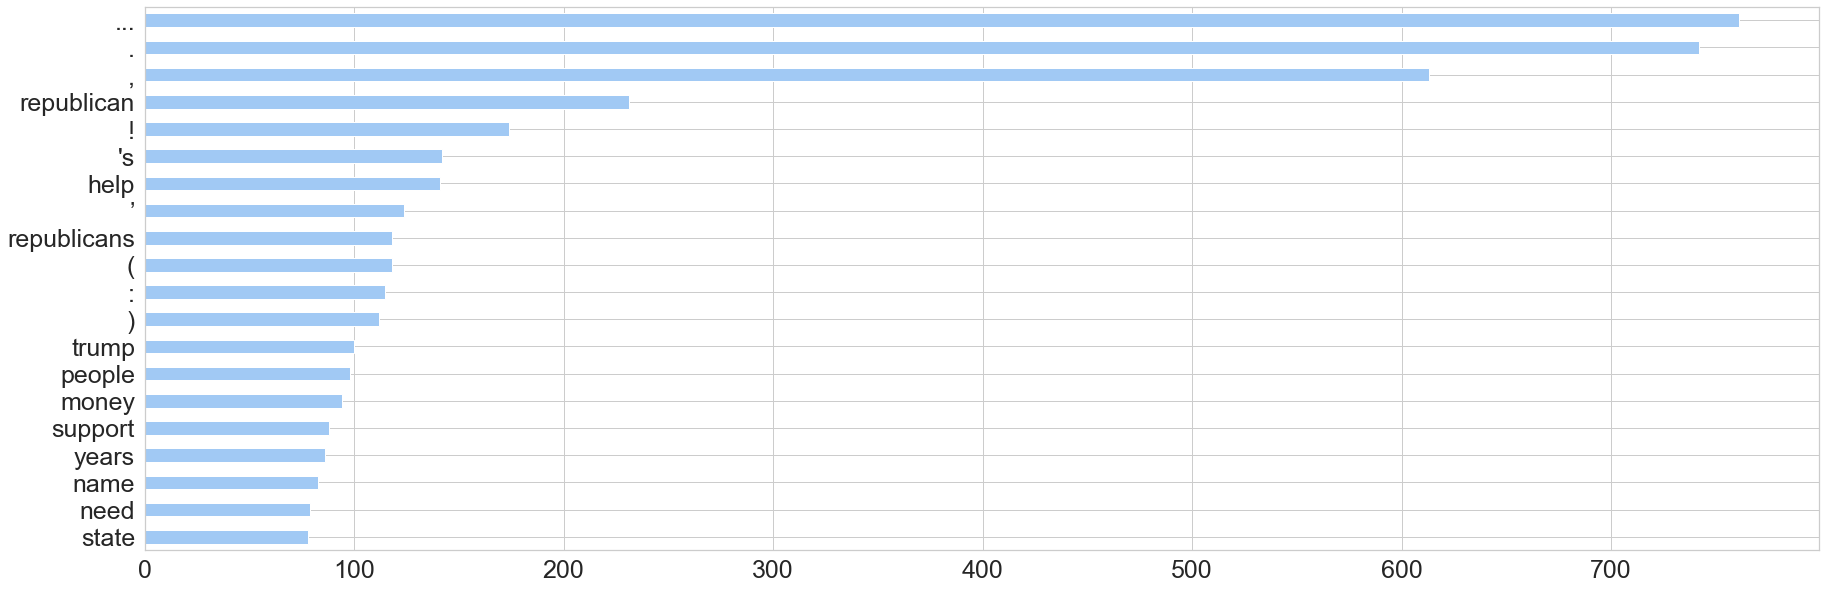

In [148]:
#top 20 values
rep_rslt.index.value_counts().head(20).sort_values(ascending=True).plot(kind='barh',figsize=(30,10))


In [5]:
# rep_rslt['count'] =1
# rep_rslt=rep_rslt.groupby('Word').agg({'count':'sum'})


In [149]:
rep_counts=pd.DataFrame(rep_rslt.index.value_counts()).reset_index()


In [150]:
rep_counts['wd_pct']=rep_counts['Word']/864*100

In [151]:
rep_counts[rep_counts['index'].str.isalpha()].sort_values('wd_pct',ascending=False)

index  Word     wd_pct
3       republican   231  26.736111
6             help   141  16.319444
8      republicans   118  13.657407
12           trump   100  11.574074
13          people    98  11.342593
14           money    94  10.879630
15         support    88  10.185185
16           years    86   9.953704
17            name    83   9.606481
18            need    79   9.143519
19           state    78   9.027778
20            time    76   8.796296
21             get    75   8.680556
23           party    74   8.564815
24        campaign    73   8.449074
26       political    71   8.217593
27       president    69   7.986111
28            like    65   7.523148
29            want    64   7.407407
31              us    62   7.175926
32             one    60   6.944444
33            many    58   6.712963
34           would    56   6.481481
35          family    55   6.365741
36            make    55   6.365741
37         country    54   6.250000
38             new    54   6.250000
39        national    53   6.134259
40            year    51   5.902778
42         america    51   5.902778
...            ...   ...        ...
3911    congestive     1   0.115741
3912        biggie     1   0.115741
3889        detest     1   0.115741
3887      appalled     1   0.115741
3860    internship     1   0.115741
3886       markets     1   0.115741
3861         smear     1   0.115741
3862       denison     1   0.115741
3863       excelle     1   0.115741
3864  installation     1   0.115741
3865    remarkable     1   0.115741
3866    delegation     1   0.115741
3867   declaration     1   0.115741
3869     obstacles     1   0.115741
3870     prejudice     1   0.115741
3871        greedy     1   0.115741
3872          cong     1   0.115741
3873         soros     1   0.115741
3874         carte     1   0.115741
3875        hawley     1   0.115741
3876        uneasy     1   0.115741
3877        voyage     1   0.115741
3878        nelson     1   0.115741
3879           pbs     1   0.115741
3880           sto     1   0.115741
3881         berke     1   0.115741
3883     quarterly     1   0.115741
3884       doubled     1   0.115741
3885        ghetto     1   0.115741
6489          whit     1   0.115741

[5859 rows x 3 columns]

In [152]:
rep_counts['index'].dtype

dtype('O')

In [153]:
rep_counts.sort_values('wd_pct',ascending=False)

index  Word     wd_pct
0              ...   761  88.078704
1                .   742  85.879630
2                ,   613  70.949074
3       republican   231  26.736111
4                !   174  20.138889
5               's   142  16.435185
6             help   141  16.319444
7                ’   124  14.351852
8      republicans   118  13.657407
9                (   118  13.657407
10               :   115  13.310185
11               )   112  12.962963
12           trump   100  11.574074
13          people    98  11.342593
14           money    94  10.879630
15         support    88  10.185185
16           years    86   9.953704
17            name    83   9.606481
18            need    79   9.143519
19           state    78   9.027778
20            time    76   8.796296
21             get    75   8.680556
22              ``    74   8.564815
23           party    74   8.564815
24        campaign    73   8.449074
25              ''    71   8.217593
26       political    71   8.217593
27       president    69   7.986111
28            like    65   7.523148
29            want    64   7.407407
...            ...   ...        ...
3889        detest     1   0.115741
3888             k     1   0.115741
3873         soros     1   0.115741
3861         smear     1   0.115741
3862       denison     1   0.115741
3863       excelle     1   0.115741
3864  installation     1   0.115741
3865    remarkable     1   0.115741
3866    delegation     1   0.115741
3867   declaration     1   0.115741
3868      30-point     1   0.115741
3869     obstacles     1   0.115741
3870     prejudice     1   0.115741
3871        greedy     1   0.115741
3872          cong     1   0.115741
3874         carte     1   0.115741
3887      appalled     1   0.115741
3875        hawley     1   0.115741
3876        uneasy     1   0.115741
3877        voyage     1   0.115741
3878        nelson     1   0.115741
3879           pbs     1   0.115741
3880           sto     1   0.115741
3881         berke     1   0.115741
3882       25-july     1   0.115741
3883     quarterly     1   0.115741
3884       doubled     1   0.115741
3885        ghetto     1   0.115741
3886       markets     1   0.115741
6489          whit     1   0.115741

[6490 rows x 3 columns]

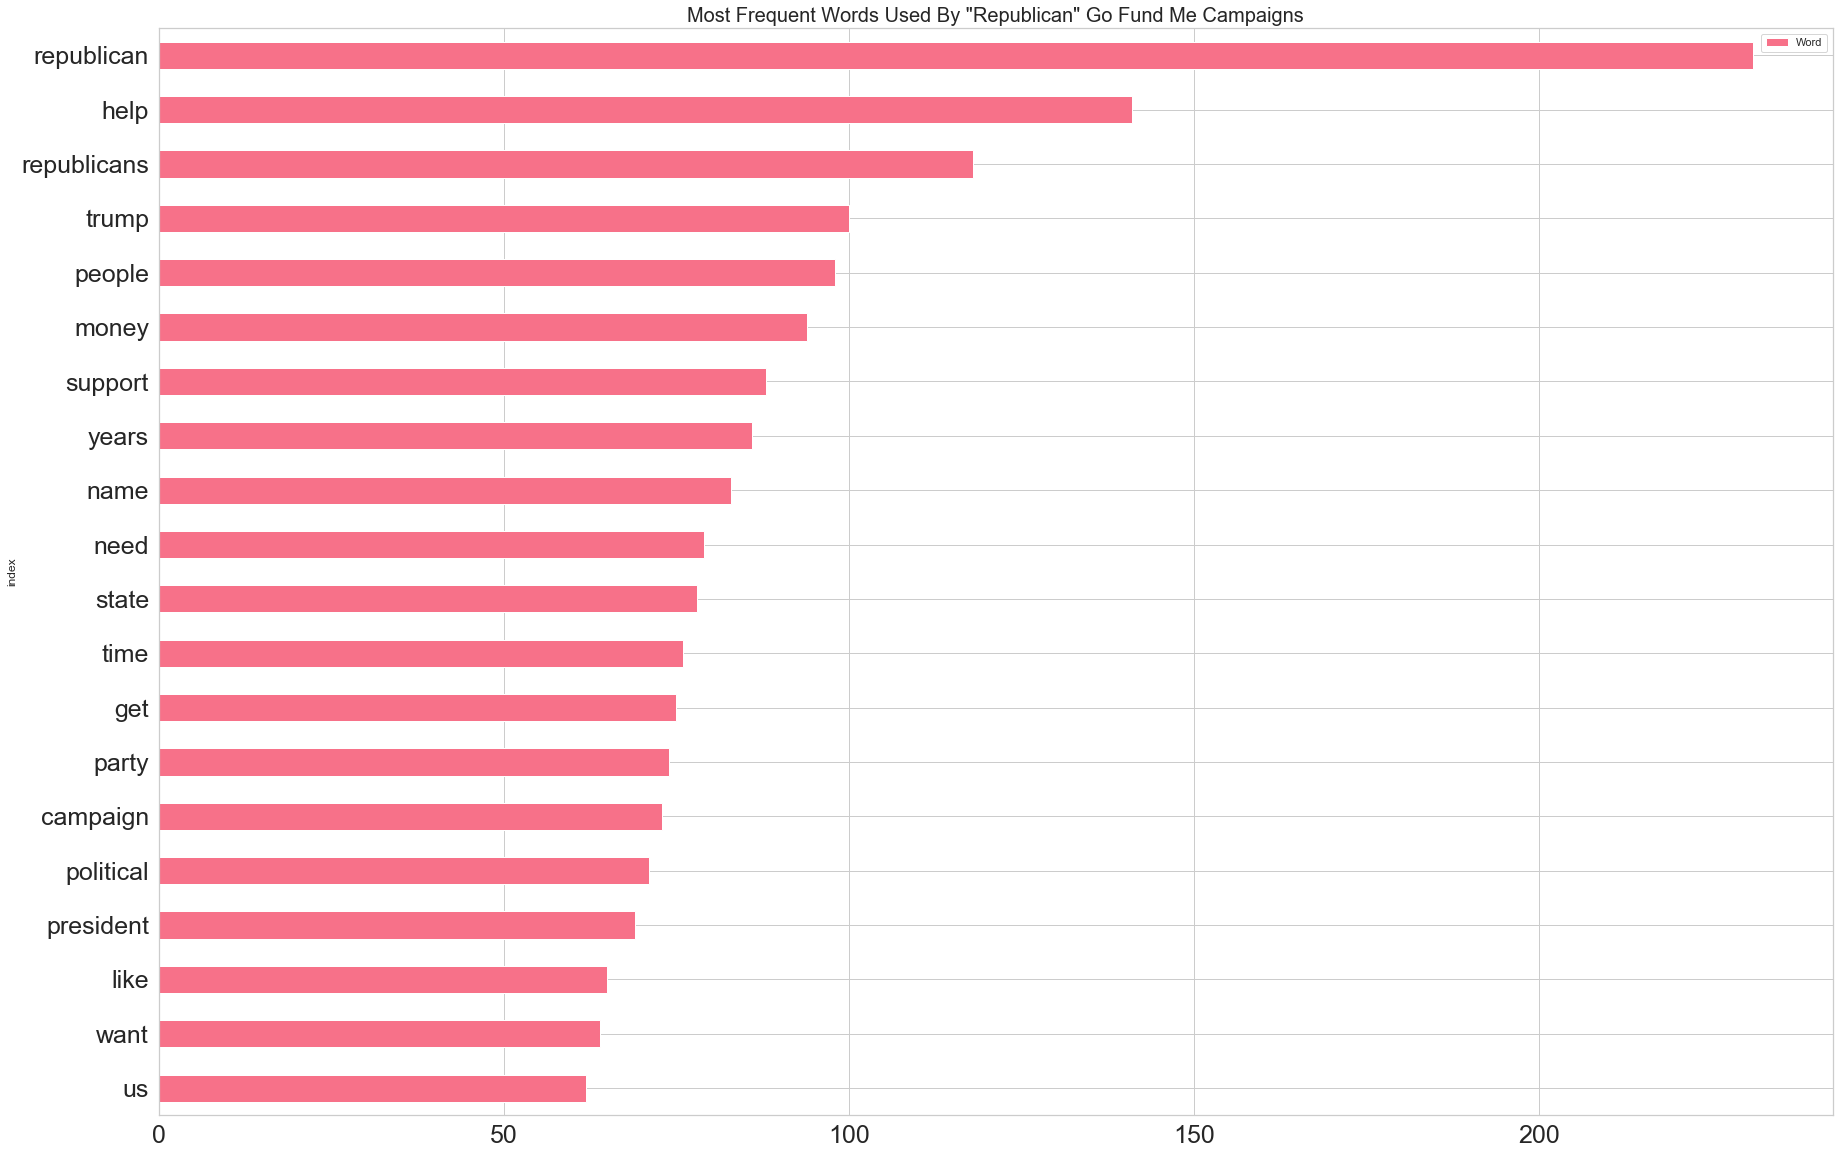

In [259]:
rep_counts[rep_counts['index'].str.isalpha()].head(20).sort_values(by='Word').plot(x='index',y='Word',kind='barh',figsize=(30,20),color='#B03190')
plt.tick_params(labelsize=25)
plt.title('Most Frequent Words Used By "Republican" Go Fund Me Campaigns',{'fontsize': 20,'fontweight' : 1})
plt.savefig("republicanwords.pdf")

Text(0.5, 1.0, 'Most Frequent Words Used By "Democrat" Go Fund Me Campaigns')

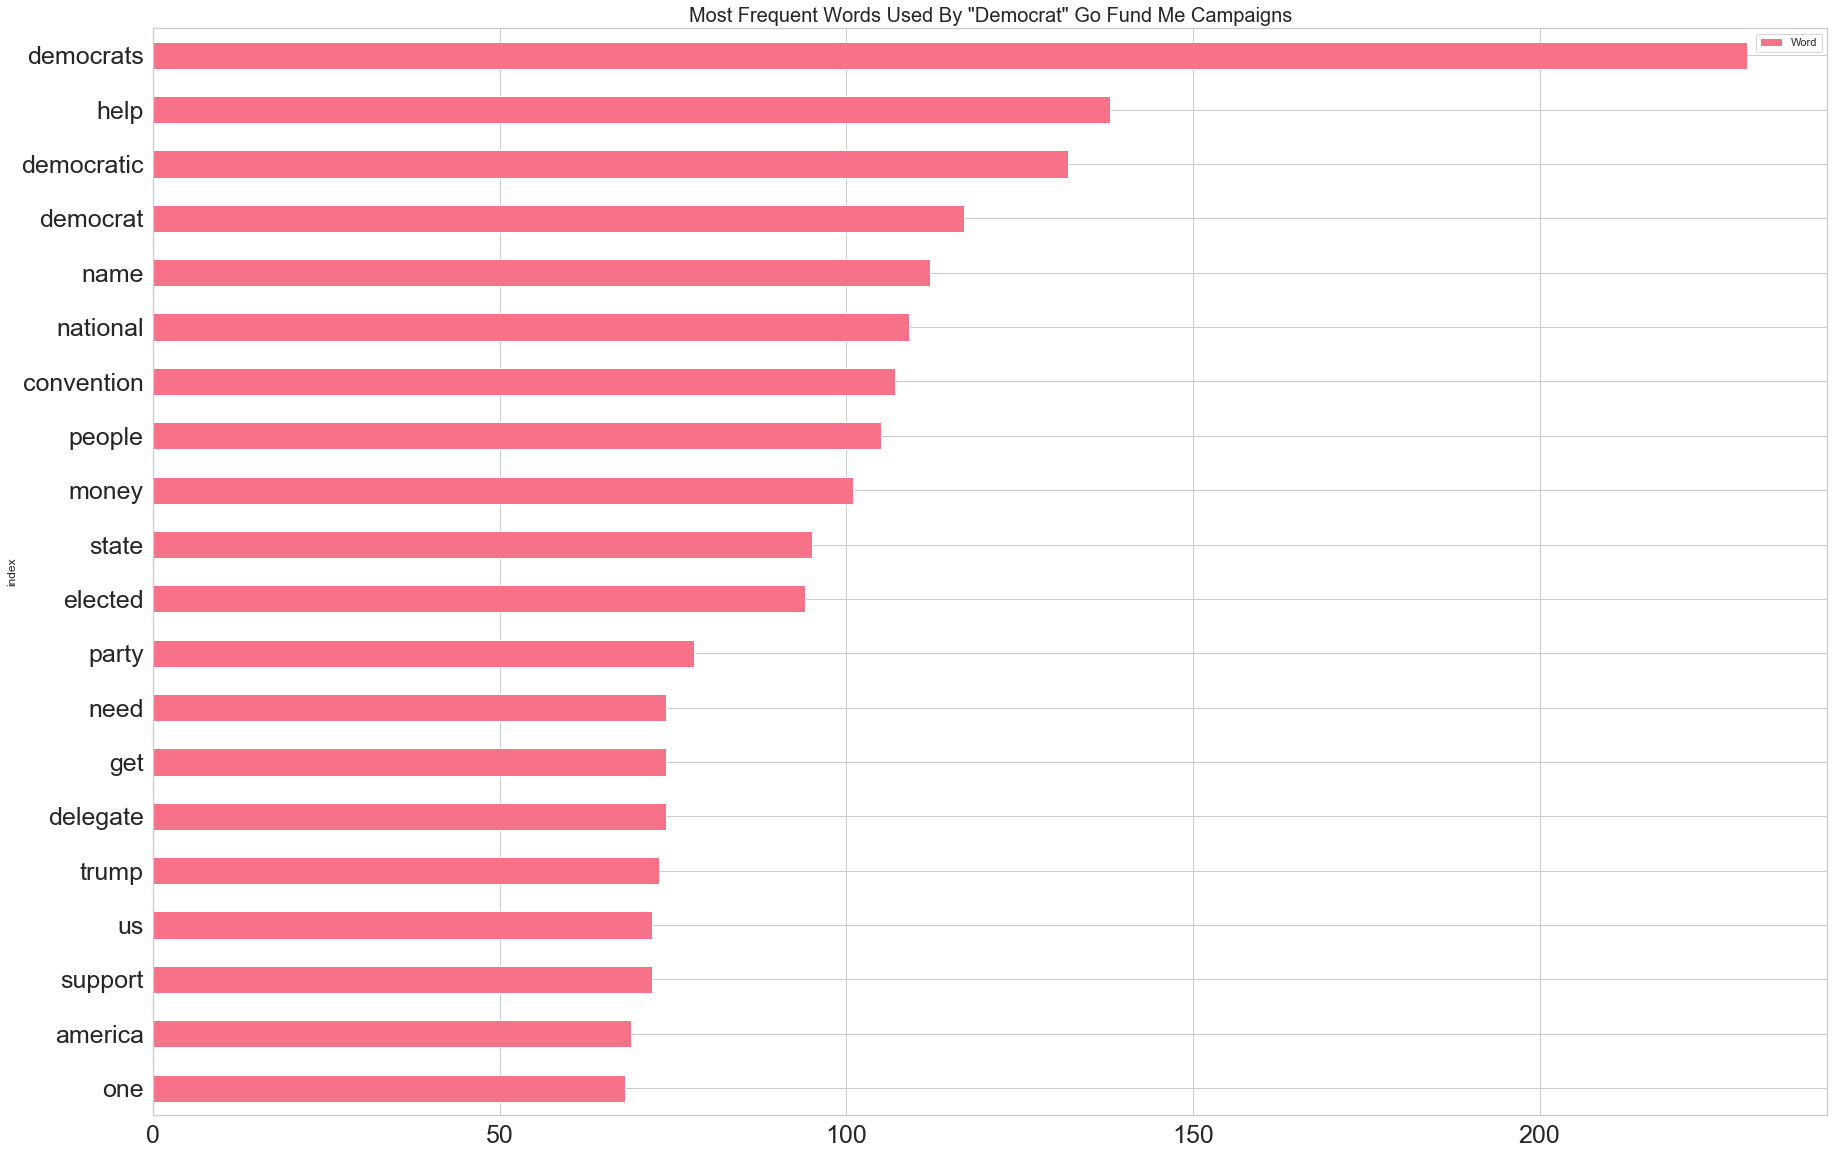

In [260]:
dem_counts[dem_counts['index'].str.isalpha()].head(20).sort_values(by='Word').plot(x='index',y='Word',kind='barh',color='#3190B0',figsize=(30,20))
plt.tick_params(labelsize=25)
plt.title('Most Frequent Words Used By "Democrat" Go Fund Me Campaigns',{'fontsize': 20,'fontweight' : 1})
# plt.savefig("democratwords.pdf")

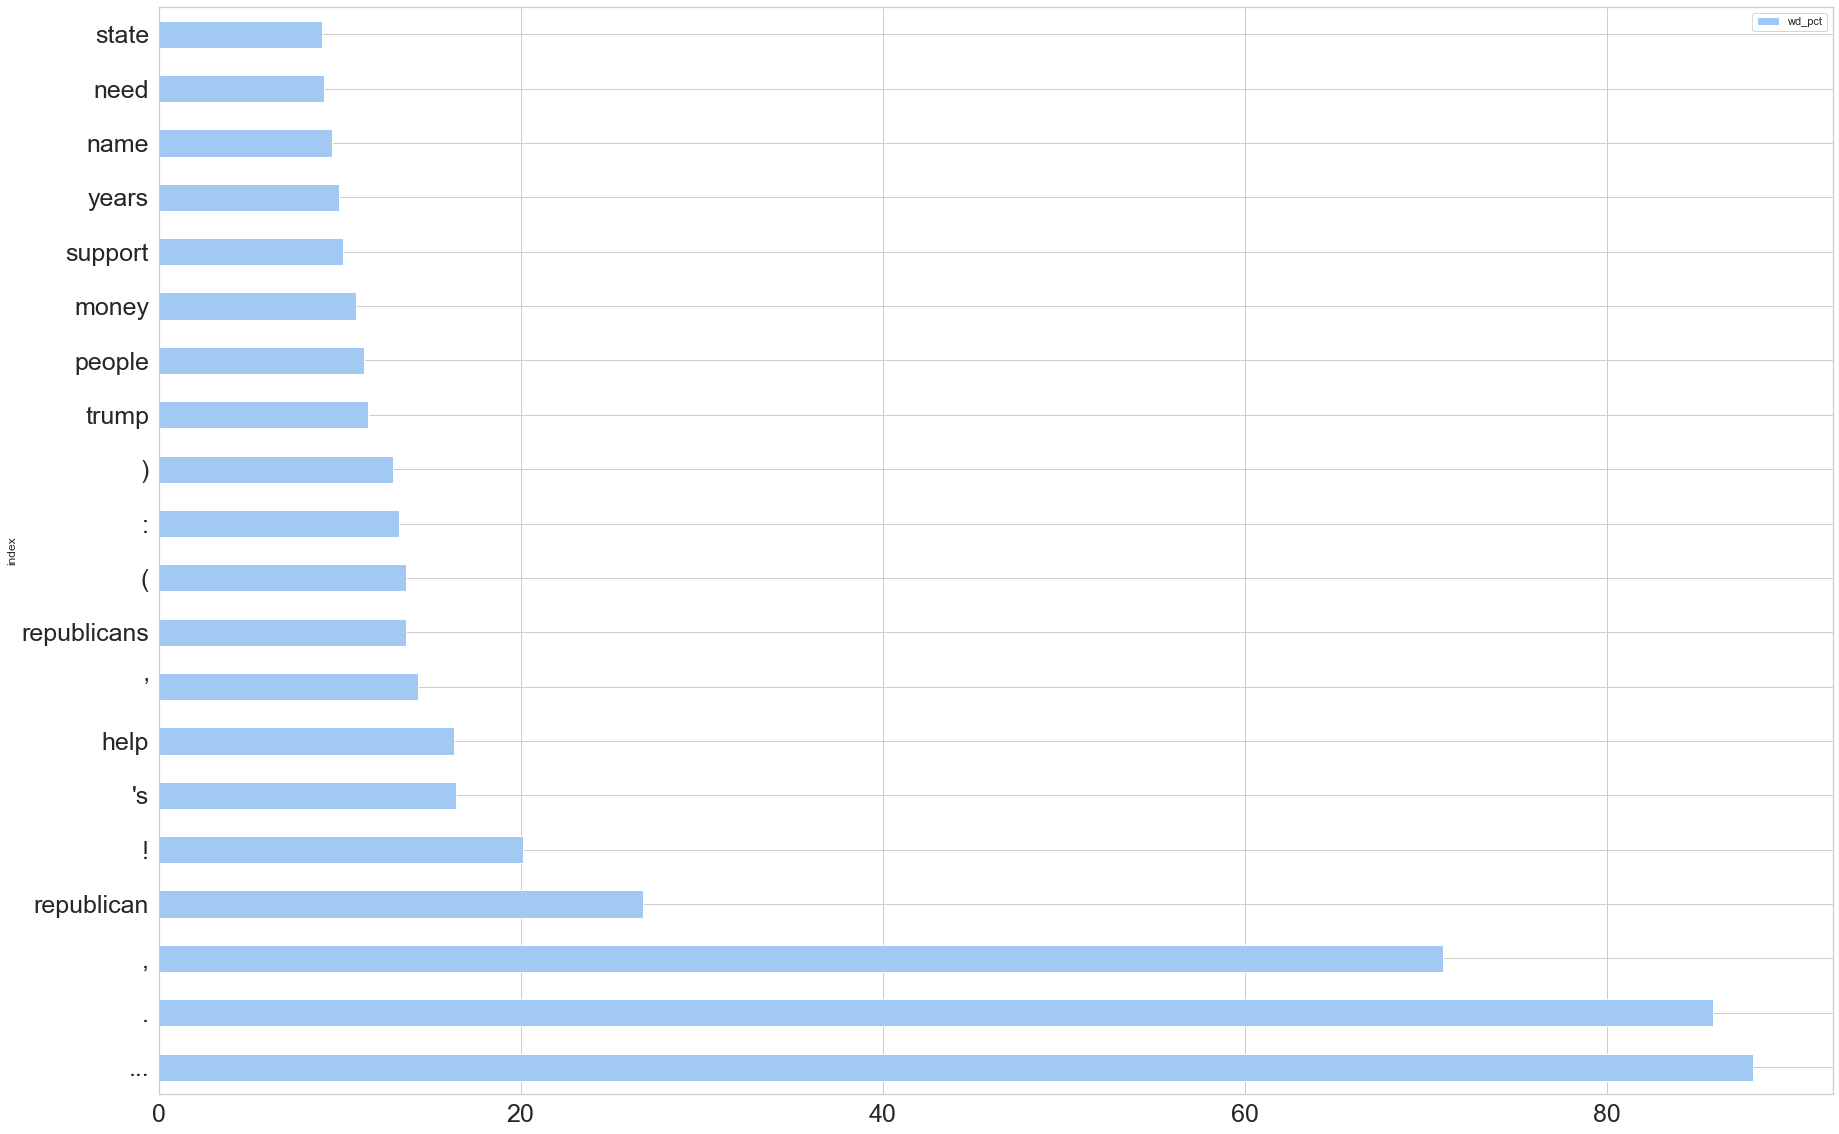

In [155]:
rep_counts[rep_counts.index.isin(['.',',','$', '--','-', '?',"'m",'``',"''",';','“','”','nonetype'])==False].head(20).plot(x='index',y='wd_pct',kind='barh',figsize=(30,20))
plt.tick_params(labelsize=25)

In [156]:
#campaigns with the word democrat
top_N = 100000
dem_rslt =pd.DataFrame()
for index, row in df[df['tag']=='dem'].iterrows():
    txt = row['summary'].lower()
    words = nltk.tokenize.word_tokenize(txt)
    word_dist = nltk.FreqDist(words)
    stopwords = nltk.corpus.stopwords.words('english')
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
    print('All frequencies, including STOPWORDS:')
    print('=' * 60)
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency'])
    print(rslt)
    print('=' * 60)
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),columns=['Word', 'Frequency']).set_index('Word')
    dem_rslt=dem_rslt.append(rslt)

All frequencies, including STOPWORDS:
                    Word  Frequency
0                     to          3
1                    the          3
2                     in          2
3                     we          2
4                   have          2
5                  raise          2
6                      a          2
7                  print          1
8                vaccine          1
9                 safety          1
10             statement          1
11                  with          1
12                   all          1
13                   our          1
14                 names          1
15                beside          1
16                    it          1
17                 press          1
18              democrat          1
19                     $          1
20                 2,268          1
21                   for          1
22                  half          1
23                  page          1
24         advertisement          1
25                     .  

            Word  Frequency
0             we          3
1             to          2
2             's          2
3            for          2
4            the          2
5            all          2
6           deep          1
7           blue          1
8             42          1
9             is          1
10             a          1
11         group          1
12            of          1
13    grassroots          1
14     democrats          1
15       running          1
16            be          1
17           our          1
18      assembly          1
19      district          1
20     delegates          1
21    california          1
22    democratic          1
23         party          1
24             .          1
25          what          1
26          this          1
27      election          1
28         about          1
29             ?          1
30         click          1
31          here          1
32       details          1
33           and          1
34          rsvp    

         Word  Frequency
0          to          4
1         and          4
2           i          3
3         our          2
4           ,          2
5        have          2
6           .          2
7           ’          2
8           t          2
9           a          2
10        due          1
11     idiots          1
12  currently          1
13         in          1
14     moving          1
15      state          1
16         my          1
17     family          1
18        had          1
19   feelings          1
20       hurt          1
21       know          1
22       this          1
23      doesn          1
24      sound          1
25       like          1
26       much          1
27        but          1
28         it          1
29          s          1
30      seems          1
31         be          1
32       good          1
33     excuse          1
34        for          1
35       most          1
36    liberal          1
37  democrats          1
38    created          1


            Word  Frequency
0             in          3
1            ccd          2
2            the          2
3              .          2
4           have          2
5            and          2
6              ,          2
7        citadel          1
8        college          1
9      democrats          1
10             (          1
11             )          1
12            is          1
13           its          1
14         first          1
15          year          1
16            of          1
17     existence          1
18           but          1
19           has          1
20          made          1
21             a          1
22          huge          1
23        impact          1
24     community          1
25            we          1
26        logged          1
27         close          1
28            to          1
29           100          1
30         hours          1
31       working          1
32            on          1
33         state          1
34       federal    

All frequencies, including STOPWORDS:
       Word  Frequency
0      just          1
1      need          1
2        to          1
3       get          1
4      away          1
5      from          1
6  politics          1
All frequencies, including STOPWORDS:
          Word  Frequency
0            .          3
1          the          3
2            ,          2
3            ’          2
4           we          2
5           to          2
6          and          2
7         when          1
8         more          1
9       people          1
10        vote          1
11   democrats          1
12         win          1
13        that          1
14           s          1
15         why          1
16          re          1
17   committed          1
18    reaching          1
19    millions          1
20          of          1
21   americans          1
22       about          1
23      voting          1
24        this          1
25        year          1
26          if          1
27         n

All frequencies, including STOPWORDS:
                   Word  Frequency
0                     ,          5
1                 funds          3
2                    to          3
3                     i          2
4                    my          2
5                     .          2
6                   the          2
7                    as          2
8                     a          2
9                    am          1
10              raising          1
11             start-up          1
12                  for          1
13  political/religious          1
14             platform          1
15                would          1
16                   go          1
17             printing          1
18                    :          1
19                books          1
20              posters          1
21              buttons          1
22               bumper          1
23             stickers          1
24              compact          1
25              mirrors          1
26               

               Word  Frequency
0               the          3
1               and          3
2                is          2
3               are          2
4               ...          2
5                to          2
6                 “          1
7              ship          1
8           sinking          1
9                 ”          1
10             most          1
11        americans          1
12            still          1
13               in          1
14             dark          1
15            about          1
16  geo-engineering          1
17              its          1
18      cataclysmic          1
19     consequences          1
20             .but          1
21           people          1
22           waking          1
23              up…          1
24             here          1
25              how          1
26              you          1
27              can          1
28               be          1
29                a          1
30             part          1
31      

All frequencies, including STOPWORDS:
               Word  Frequency
0                 ,          6
1               and          3
2                to          3
3               sue          2
4               her          2
5                 .          2
6                's          2
7   hessel—personal          1
8         historian          1
9            gifted          1
10           writer          1
11     humanitarian          1
12             wife          1
13              mom          1
14           granny          1
15           friend          1
16              all          1
17                (          1
18       especially          1
19        democrats          1
20                )          1
21             —has          1
22            spent          1
23             life          1
24           giving          1
25           freely          1
26           others          1
27          through          1
28           myriad          1
29            roles          1
3

All frequencies, including STOPWORDS:
         Word  Frequency
0      family          2
1           !          2
2        this          2
3        year          2
4         the          2
5           a          2
6          as          2
7       hello          1
8     friends          1
9         and          1
10          ,          1
11    college          1
12  democrats          1
13         at          1
14         uc          1
15        san          1
16      diego          1
17       will          1
18         be          1
19    hosting          1
20         of          1
21          6          1
22        for          1
23   holidays          1
24    through          1
25  operation          1
26      santa          1
27          .          1
28     please          1
29   consider          1
30   donating          1
31       much          1
32        you          1
33        can          1
34         to          1
35       help          1
36         us          1
37       mak

          Word  Frequency
0           we          3
1            ,          3
2           to          3
3            !          2
4          the          2
5            .          2
6           us          2
7          and          2
8     facebook          2
9          has          2
10        ￼￼￼￼          1
11         hey          1
12        guys          1
13          do          1
14         not          1
15     receive          1
16    millions          1
17        from          1
18  government          1
19      george          1
20       soros          1
21          or          1
22     silicon          1
23      valley          1
24         are          1
25   supported          1
26          by          1
27         you          1
28      people          1
29        here          1
30          at          1
31   'lgbtrump          1
32           -          1
33        gays          1
34         for          1
35       trump          1
36           '          1
37        wa

All frequencies, including STOPWORDS:
          Word  Frequency
0            i          6
1          and          4
2            .          3
3        didnt          2
4           to          2
5            ,          2
6            a          2
7       update          1
8            :          1
9    initially          1
10          go          1
11      public          1
12        with          1
13        this          1
14     because          1
15        want          1
16     trouble          1
17      anyone          1
18     figured          1
19         had          1
20        time          1
21     regroup          1
22        land          1
23         new          1
24         job          1
25         did          1
26      inform          1
27          my          1
28     closest          1
29     friends          1
30      family          1
31         for          1
32   emotional          1
33     support          1
34        they          1
35        have          1


All frequencies, including STOPWORDS:
           Word  Frequency
0           and          3
1   doucheleaks          2
2           the          2
3            on          2
4         media          2
5             (          2
6             )          2
7        parody          2
8             ,          2
9          will          2
10          for          2
11           is          1
12       coming          1
13            !          1
14           to          1
15        fight          1
16      growing          1
17   censorship          1
18      twitter          1
19       social          1
20           my          1
21   inevitable          1
22          ban          1
23            i          1
24           'm          1
25     creating          1
26            a          1
27      website          1
28       titled          1
29        which          1
30       launch          1
31        march          1
32         31st          1
33            .          1
34         this  

All frequencies, including STOPWORDS:
          Word  Frequency
0            ,          3
1           of          3
2            a          3
3          for          2
4       occupy          2
5          and          2
6            i          2
7          the          2
8            .          2
9           in          2
10   searching          1
11          by          1
12     crystal          1
13       zevon          1
14        last          1
15        year          1
16       after          1
17       years          1
18     signing          1
19    internet          1
20   petitions          1
21         not          1
22      seeing          1
23    anything          1
24      change          1
25    embraced          1
26    movement          1
27       lived          1
28        tent          1
29      middle          1
30  washington          1
31        d.c.          1
32           4          1
33      months          1
34     through          1
35  snowstorms          1


All frequencies, including STOPWORDS:
            Word  Frequency
0            the          4
1             to          3
2      president          2
3          taxes          2
4              ?          2
5            are          2
6              ,          2
7             's          2
8             we          2
9            why          1
10          does          1
11           n't          1
12           pay          1
13         where          1
14           his          1
15           tax          1
16       returns          1
17      inspired          1
18            by          1
19          last          1
20           few          1
21        months          1
22            of          1
23       protest          1
24  particularly          1
25         women          1
26         march          1
27         going          1
28  relentlessly          1
29        demand          1
30            on          1
31         april          1
32          15th          1
33        

All frequencies, including STOPWORDS:
            Word  Frequency
0            the          3
1              .          2
2              i          2
3       national          2
4             at          2
5       missouri          2
6     democratic          2
7     convention          2
8             my          1
9           name          1
10            is          1
11         derek          1
12         evans          1
13           was          1
14       elected          1
15            as          1
16            an          1
17      at-large          1
18      delegate          1
19           for          1
20        bernie          1
21       sanders          1
22         party          1
23         state          1
24          will          1
25            be          1
26  representing          1
27            by          1
28      bringing          1
29     political          1
30    revolution          1
31            to          1
32  philadelphia          1
33        

All frequencies, including STOPWORDS:
         Word  Frequency
0           ,          8
1         the          2
2          by          2
3         her          2
4         and          2
5         for          2
6        most          1
7    horrific          1
8       words          1
9         you          1
10      could          1
11       ever          1
12       hear          1
13          :          1
14       your          1
15     mother          1
16     sister          1
17       wife          1
18         or          1
19   daughter          1
20        has          1
21       been          1
22   brutally          1
23   attacked          1
24          a          1
25   predator          1
26       body          1
27  mutilated          1
28      raped          1
29   tortured          1
30       then          1
31       left          1
32       dead          1
33          .          1
34       only          1
35    posting          1
36         on          1
37   faceboo

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          5
1           and          4
2           you          3
3       elected          2
4           for          2
5       senator          2
6       sanders          2
7            if          2
8         needs          2
9            my          1
10         name          1
11           is          1
12        susan          1
13         soto          1
14       palmer          1
15            i          1
16          was          1
17           on          1
18         june          1
19           19          1
20         2016          1
21           as          1
22            a          1
23        party          1
24       leader          1
25     official          1
26            (          1
27         pleo          1
28            )          1
29     delegate          1
30       bernie          1
31            .          1
32      support          1
33          the          1
34    political  

All frequencies, including STOPWORDS:
          Word  Frequency
0            i          4
1           in          3
2            .          3
3           to          3
4          the          3
5            ,          2
6          had          2
7          and          2
8            (          1
9           tl          1
10           ;          1
11          dr          1
12        bold          1
13           )          1
14          my          1
15        name          1
16          is          1
17     matthew          1
18       leahy          1
19     friends          1
20        call          1
21          me          1
22        matt          1
23          or          1
24       mateo          1
25         not          1
26    everyone          1
27       finds          1
28       their          1
29     calling          1
30        when          1
31        they          1
32         are          1
33      junior          1
34        high          1
35        2008          1


           Word  Frequency
0             i          6
1            my          5
2           and          3
3           've          3
4             .          3
5   information          2
6            to          2
7          been          2
8             a          2
9          have          1
10         more          1
11        about          1
12         trip          1
13       philly          1
14       likely          1
15     expenses          1
16            ,          1
17           so          1
18      lowered          1
19         goal          1
20           in          1
21   accordance          1
22         with          1
23         that          1
24         name          1
25           is          1
26        bruce          1
27        fealk          1
28         life          1
29         long          1
30     democrat          1
31           ca          1
32          n't          1
33         even          1
34      contain          1
35   excitement          1
3

All frequencies, including STOPWORDS:
            Word  Frequency
0            and          4
1             to          3
2              .          3
3              ,          2
4            for          2
5        appeals          2
6             in          2
7            she          2
8        welcome          1
9          thank          1
10           you          1
11        taking          1
12          time          1
13       inquire          1
14      consider          1
15        voting          1
16  contributing          1
17             a          1
18        fellow          1
19       citizen          1
20       michele          1
21       chimene          1
22            is          1
23       running          1
24            be          1
25            an          1
26       justice          1
27      position          1
28             8          1
29           the          1
30          14th          1
31         court          1
32            of          1
33        

          Word  Frequency
0          the          5
1           of          3
2           to          3
3    delegates          3
4            ,          2
5            i          2
6           vt          2
7   convention          2
8            .          2
9           's          2
10      bernie          2
11        with          1
12     support          1
13        over          1
14          35          1
15      donors          1
16      raised          1
17       about          1
18           $          1
19         850          1
20       cover          1
21       costs          1
22     leading          1
23          up          1
24          on          1
25         may          1
26          22          1
27      became          1
28         one          1
29     vermont          1
30  democratic          1
31    national          1
32         for          1
33     sanders          1
34         all          1
35     elected          1
36         are          1
37         a

All frequencies, including STOPWORDS:
             Word  Frequency
0             the          4
1         elected          3
2              to          3
3               .          3
4               ,          2
5               i          2
6             was          2
7      convention          2
8              in          2
9             for          2
10              4          2
11        friends          1
12              a          1
13       delegate          1
14     democratic          1
15       national          1
16   philadelphia          1
17             it          1
18             is          1
19             an          1
20          honor          1
21             be          1
22      represent          1
23      democrats          1
24           from          1
25            1st          1
26  congressional          1
27       district          1
28         oregon          1
29             at          1
30             we          1
31              9          1
32   

             Word  Frequency
0             the          6
1             for          2
2              of          2
3          london          2
4           lamar          2
5              in          2
6           young          2
7            this          1
8        campaign          1
9             has          1
10           been          1
11        created          1
12             to          1
13           help          1
14        support          1
15        tuition          1
16  participation          1
17          nobel          1
18          women          1
19     leadership          1
20       training          1
21            and          1
22    educational          1
23    development          1
24      institute          1
25              .          1
26             is          1
27      president          1
28      tennessee          1
29      democrats          1
30              ,          1
31        premier          1
32     democratic          1
33   organizat

All frequencies, including STOPWORDS:
              Word  Frequency
0               of          4
1           meriam          3
2              the          3
3       democratic          2
4               as          2
5              and          2
6             help          1
7               me          1
8             send          1
9          reynosa          1
10              to          1
11        national          1
12      convention          1
13               !          1
14          having          1
15             had          1
16       privilege          1
17         serving          1
18            with          1
19            both          1
20  co-secretaries          1
21         alameda          1
22          county          1
23           party          1
24   co-presidents          1
25            east          1
26           south          1
27             bay          1
28           young          1
29       democrats          1
30               ,          1
31

All frequencies, including STOPWORDS:
       Word  Frequency
0   summary          1
1       was          1
2  nonetype          1
All frequencies, including STOPWORDS:
           Word  Frequency
0       delaney          3
1            is          3
2             .          3
3     incumbent          2
4       charles          2
5            l.          2
6     assistant          2
7         judge          2
8    chittenden          2
9        county          2
10           he          2
11            -          1
12         vote          1
13     november          1
14          6th          1
15           an          1
16         here          1
17           in          1
18          has          1
19       served          1
20          two          1
21        terms          1
22            ,          1
23            8          1
24        years          1
25            a          1
26     lifelong          1
27     democrat          1
28       earned          1
29          the       

All frequencies, including STOPWORDS:
           Word  Frequency
0             i          6
1           you          5
2          rich          4
3           ass          3
4             .          3
5           and          3
6             ’          3
7            to          2
8             a          2
9            me          2
10          now          1
11           is          1
12         your          1
13       chance          1
14      finally          1
15         have          1
16       friend          1
17       ballin          1
18         make          1
19        could          1
20         tell          1
21       people          1
22         that          1
23         once          1
24         knew          1
25       before          1
26          was          1
27  millionaire          1
28       donate          1
29     whatever          1
30          can          1
31      promise          1
32         when          1
33            m          1
34            ,  

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          3
1           our          2
2             !          2
3            of          2
4           and          2
5     president          2
6         trump          2
7            to          2
8             .          2
9       country          1
10           is          1
11        under          1
12        siege          1
13     millions          1
14     illegals          1
15         pour          1
16           in          1
17      through          1
18     southern          1
19       border          1
20     bringing          1
21        crime          1
22      disease          1
23        death          1
24  immortality          1
25         like          1
26            a          1
27     majority          1
28    americans          1
29           we          1
30      elected          1
31       donald          1
32            j          1
33         make          1
34      america  

All frequencies, including STOPWORDS:
                 Word  Frequency
0                  to          3
1                   i          2
2                   a          2
3                 and          2
4                 the          2
5                   .          2
6                  we          2
7               story          2
8            invested          1
9          everything          1
10              owned          1
11              build          1
12         production          1
13               team          1
14               http          1
15                  :          1
16  //nighttalker.com          1
17              radio          1
18               show          1
19                 in          1
20                new          1
21               york          1
22               just          1
23                 as          1
24               were          1
25            gaining          1
26        significant          1
27          worldwide          1
28   

           Word  Frequency
0             i          4
1             ,          2
2         would          2
3            if          2
4            to          2
5            of          2
6             .          2
7       looking          1
8            at          1
9           how          1
10    americans          1
11   especially          1
12    democrats          1
13         have          1
14           no          1
15      problem          1
16        given          1
17         rich          1
18      corrupt          1
19  politicians          1
20          and          1
21         govt          1
22    officials          1
23        money          1
24      thought          1
25          see          1
26        these          1
27         very          1
28         same          1
29       people          1
30       donate          1
31            a          1
32       better          1
33        cause          1
34      helping          1
35          pay          1
3

                Word  Frequency
0                and          4
1                the          3
2             option          3
3                 to          3
4             border          2
5                 my          2
6         engineered          2
7         technology          2
8             before          1
9                you          1
10               now          1
11                is          1
12              best          1
13            secure          1
14               end          1
15            future          1
16         shutdowns          1
17              over          1
18          southern          1
19          security          1
20           through          1
21          patented          1
22                 .          1
23          physical          1
24              wall          1
25  state-of-the-art          1
26             smart          1
27                 ,          1
28          together          1
29           provide          1
30      

               Word  Frequency
0               the          5
1                 ,          4
2                of          4
3                in          2
4                is          2
5              late          1
6              2018          1
7        republican          1
8             party          1
9          received          1
10         greatest          1
11        christmas          1
12             gift          1
13              all          1
14             time          1
15         election          1
16             rep.          1
17       alexandria          1
18    ocasio-cortez          1
19               to          1
20               us          1
21            house          1
22  representatives          1
23                .          1
24              not          1
25             only          1
26              she          1
27              one          1
28            least          1
29         informed          1
30          elected          1
31      

All frequencies, including STOPWORDS:
                  Word  Frequency
0                    ,         12
1                party          2
2                   to          2
3    representusdothan          1
4                   is          1
5                  for          1
6        post-partisan          1
7               people          1
8                    (          1
9             liberals          1
10       conservatives          1
11        progressives          1
12           moderates          1
13        independents          1
14        libertarians          1
15           democrats          1
16         republicans          1
17                 tea          1
18               green          1
19  constitutionalists          1
20           americans          1
21                 etc          1
22                   .          1
23                   )          1
24                 who          1
25                want          1
26              create          1
27        

           Word  Frequency
0             .          4
1           the          3
2            is          3
3             i          3
4             (          2
5            to          2
6            me          2
7          just          2
8          know          2
9             a          2
10           do          2
11         that          2
12            ,          2
13         have          2
14          you          2
15         only          1
16         half          1
17           of          1
18  description          1
19        below          1
20    pertinent          1
21     campaign          1
22         rest          1
23      letting          1
24       anyone          1
25          who          1
26        wants          1
27           ``          1
28          get          1
29           ''          1
30      little-          1
31            )          1
32           hi          1
33            !          1
34           so          1
35           'm          1
3

All frequencies, including STOPWORDS:
             Word  Frequency
0             the          3
1              of          3
2          county          3
3               ,          3
4              to          2
5               i          2
6              am          2
7             for          2
8        recorder          2
9          newton          2
10        indiana          2
11      dedicated          1
12     preserving          1
13            our          1
14        history          1
15          hello          1
16              !          1
17        running          1
18         office          1
19              .          1
20             as          1
21              a          1
22          title          1
23     abstractor          1
24            who          1
25          works          1
26           with          1
27  approximately          1
28             30          1
29        offices          1
30     throughout          1
31          state          1
32   

All frequencies, including STOPWORDS:
         Word  Frequency
0           .          4
1         the          3
2        will          2
3   billboard          2
4          no          2
5       money          1
6          be          1
7        used          1
8          to          1
9         buy          1
10          a          1
11       near          1
12   brooklyn          1
13       iowa          1
14       have          1
15       this          1
16  christian          1
17     bajina          1
18     rivera          1
19         's          1
20      photo          1
21         on          1
22         it          1
23       with          1
24     slogan          1
25         ``          1
26       vote          1
27   democrat          1
28          :          1
29     border          1
30       wall          1
31       just          1
32      death          1
33        for          1
34        you          1
35        all          1
36         ''          1
All frequenc

All frequencies, including STOPWORDS:
                                                 Word  Frequency
0                                                 and          3
1                                               after          2
2                                                   ,          2
3                                               https          1
4                                                   :          1
5   //www.appeal-democrat.com/news/camp-fire-force...          1
6                                                   i          1
7                                                  'm          1
8                                              trying          1
9                                                  to          1
10                                               help          1
11                                             people          1
12                                               this          1
13                                           disaste

All frequencies, including STOPWORDS:
           Word  Frequency
0            in          3
1           are          2
2      american          2
3           and          2
4            we          1
5             a          1
6     patriotic          1
7    grassroots          1
8      campaign          1
9          firm          1
10    dedicated          1
11           to          1
12   protecting          1
13      culture          1
14    liberties          1
15            .          1
16        ilhan          1
17         omar          1
18         2020          1
19         must          1
20           be          1
21      removed          1
22         from          1
23       office          1
24            !          1
25      already          1
26          her          1
27     district          1
28        flags          1
29       coming          1
30         down          1
31            ,          1
32          the          1
33       pledge          1
34           of  

All frequencies, including STOPWORDS:
            Word  Frequency
0              .          5
1           vote          3
2              i          2
3             to          2
4       democrat          2
5           goal          2
6          right          1
7            now          1
8              ,          1
9     republican          1
10           can          1
11             ’          1
12             t          1
13        afford          1
14       raising          1
15         money          1
16        switch          1
17         sides          1
18          will          1
19      straight          1
20        ticket          1
21            if          1
22            is          1
23           met          1
24        before          1
25  presidential          1
26      election          1
27        please          1
28          help          1
29            me          1
30         reach          1
31            my          1
All frequencies, including STOPWORDS:


           Word  Frequency
0             .          3
1             i          3
2           the          3
3            'm          2
4       running          2
5           for          2
6             a          2
7            my          1
8          name          1
9            is          1
10  christopher          1
11           l.          1
12         reed          1
13     district          1
14           10          1
15     position          1
16       within          1
17   washington          1
18        state          1
19  legislature          1
20          why          1
21           do          1
22         need          1
23         your          1
24        money          1
25            ?          1
26       simple          1
27            :          1
28      because          1
29         just          1
30         self          1
31     employed          1
32        local          1
33          man          1
34         that          1
35           's          1
3

All frequencies, including STOPWORDS:
             Word  Frequency
0               .          4
1              is          3
2           ringg          3
3          leeder          3
4               ?          2
5               ’          2
6               a          2
7   point-of-view          2
8   entertainment          2
9            what          1
10         unlike          1
11       anything          1
12            you          1
13             ve          1
14           ever          1
15           seen          1
16         before          1
17         comedy          1
18           show          1
19           from          1
20      different          1
21             it          1
22              s          1
23           with          1
24             an          1
25    unabashedly          1
26   conservative          1
27              ,          1
28       populist          1
29            can          1
30           that          1
31             be          1
32   

         Word  Frequency
0           .          3
1         let          2
2       money          2
3           i          2
4          to          2
5           ’          1
6           s          1
7        give          1
8       these          1
9   democrats          1
10          a          1
11        run          1
12        for          1
13      their          1
14       want          1
15      raise          1
16     enough          1
17         on          1
18         my          1
19        end          1
20    support          1
21        the          1
22       race          1
23       will          1
24        not          1
25        sit          1
26         by          1
27        and          1
28     sleepy          1
29        joe          1
30         or          1
31    crooked          1
32     hilary          1
33       take          1
34        our          1
35  president          1
36        out          1
37         of          1
38        his          1


All frequencies, including STOPWORDS:
           Word  Frequency
0           gun          3
1             .          3
2            to          3
3            we          2
4        county          2
5           the          2
6      violence          2
7            in          2
8           our          2
9            is          2
10           at          1
11         polk          1
12        young          1
13    democrats          1
14      believe          1
15         that          1
16        issue          1
17           of          1
18          has          1
19          n't          1
20         been          1
21    discussed          1
22  communities          1
23         loud          1
24       enough          1
25          are          1
26       taking          1
27            a          1
28        stand          1
29          end          1
30      silence          1
31           on          1
32           it          1
33         time          1
34       demand  

All frequencies, including STOPWORDS:
              Word  Frequency
0              his          3
1               of          3
2              and          3
3               as          2
4                a          2
5                i          2
6             that          2
7              the          2
8                .          2
9             just          2
10         liberal          1
11        democrat          1
12            find          1
13             new          1
14  administration          1
15           fails          1
16              in          1
17             its          1
18            role          1
19              to          1
20            lead          1
21          wisely          1
22              or          1
23            with          1
24             any          1
25      compassion          1
26            lies          1
27             are          1
28      compounded          1
29              by          1
30             all          1
31

In [157]:
dem_rslt.index.value_counts()

...               753
.                 735
,                 625
democrats         230
!                 198
's                144
help              138
democratic        132
democrat          117
name              112
national          109
(                 107
convention        107
:                 106
)                 106
people            105
money             101
’                  99
state              95
elected            94
party              78
need               74
get                74
delegate           74
trump              73
us                 72
support            72
america            69
one                68
president          66
                 ... 
backgrounds         1
celia               1
visited             1
staff               1
josh                1
financi             1
initially           1
onward              1
engineer            1
bindner             1
reward              1
benef               1
placement           1
57                  1
altwheaste

In [158]:
dem_counts=pd.DataFrame(dem_rslt.index.value_counts()).reset_index()
dem_counts['wd_pct']=dem_counts['Word']/850*100

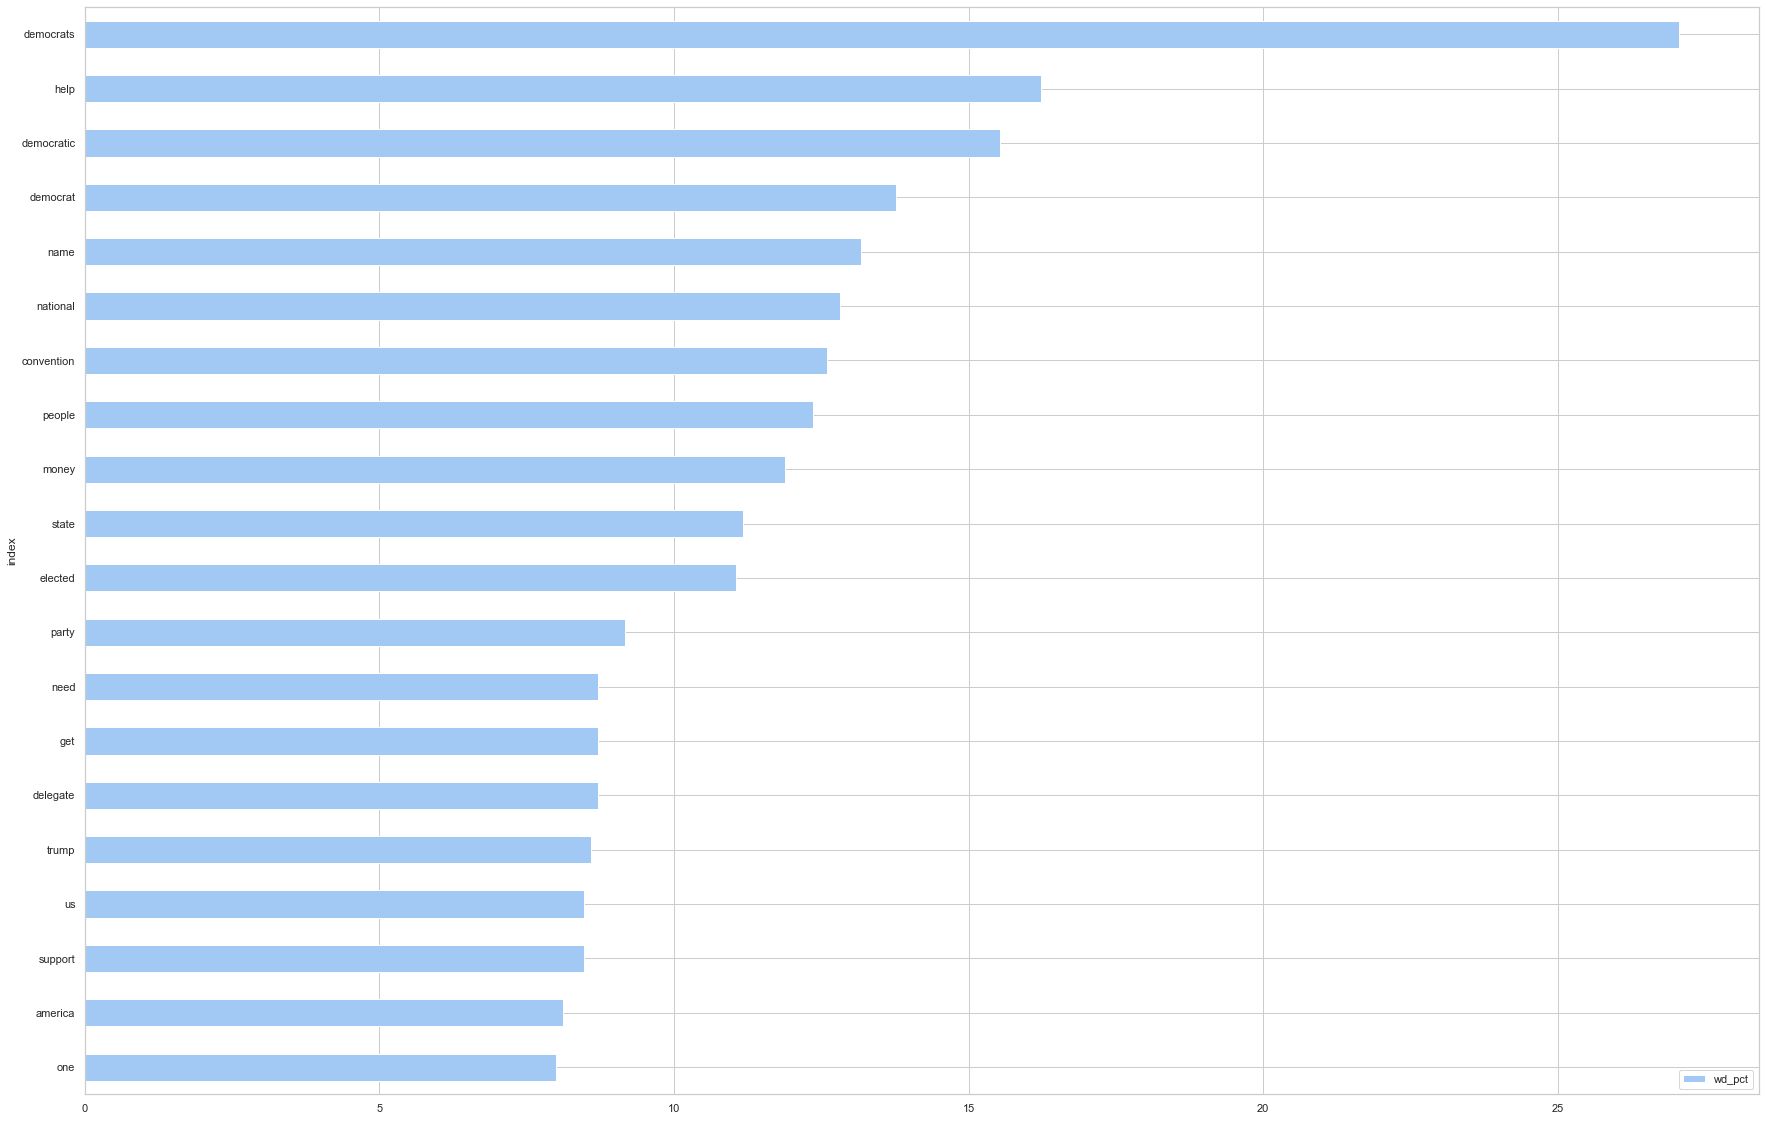

In [159]:
dem_counts[dem_counts['index'].str.isalpha()].sort_values(by='wd_pct',ascending=False).head(20).sort_values(by='wd_pct',ascending=True).plot(x='index',y='wd_pct',kind='barh',figsize=(30,20))

In [160]:
#all words
top_N = 500
txt = df['summary'].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
print('All frequencies, including STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
print(rslt)
print('=' * 60)
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

All frequencies, including STOPWORDS:
            Word  Frequency
0            the       3842
1              ,       3284
2              .       3065
3             to       2972
4            and       2398
5              a       1969
6              i       1910
7             of       1825
8            ...       1584
9             in       1580
10           for       1263
11            is       1161
12            my        766
13            we        748
14          this        615
15          that        615
16            on        605
17             !        598
18           our        579
19          have        548
20           are        540
21            as        518
22            be        467
23          will        461
24            am        456
25           you        447
26           was        444
27          with        429
28            it        370
29            's        356
..           ...        ...
470         kids         23
471       needed         23
472  indep

In [161]:
#combining rep and dem counts dataframs
rep_counts['tag']='rep'
dem_counts['tag']='dem'
words_df=rep_counts.append(dem_counts)
words_df=words_df.reset_index()


In [162]:
# getting rid of characters
words_df=words_df[words_df['index'].str.isalpha()]

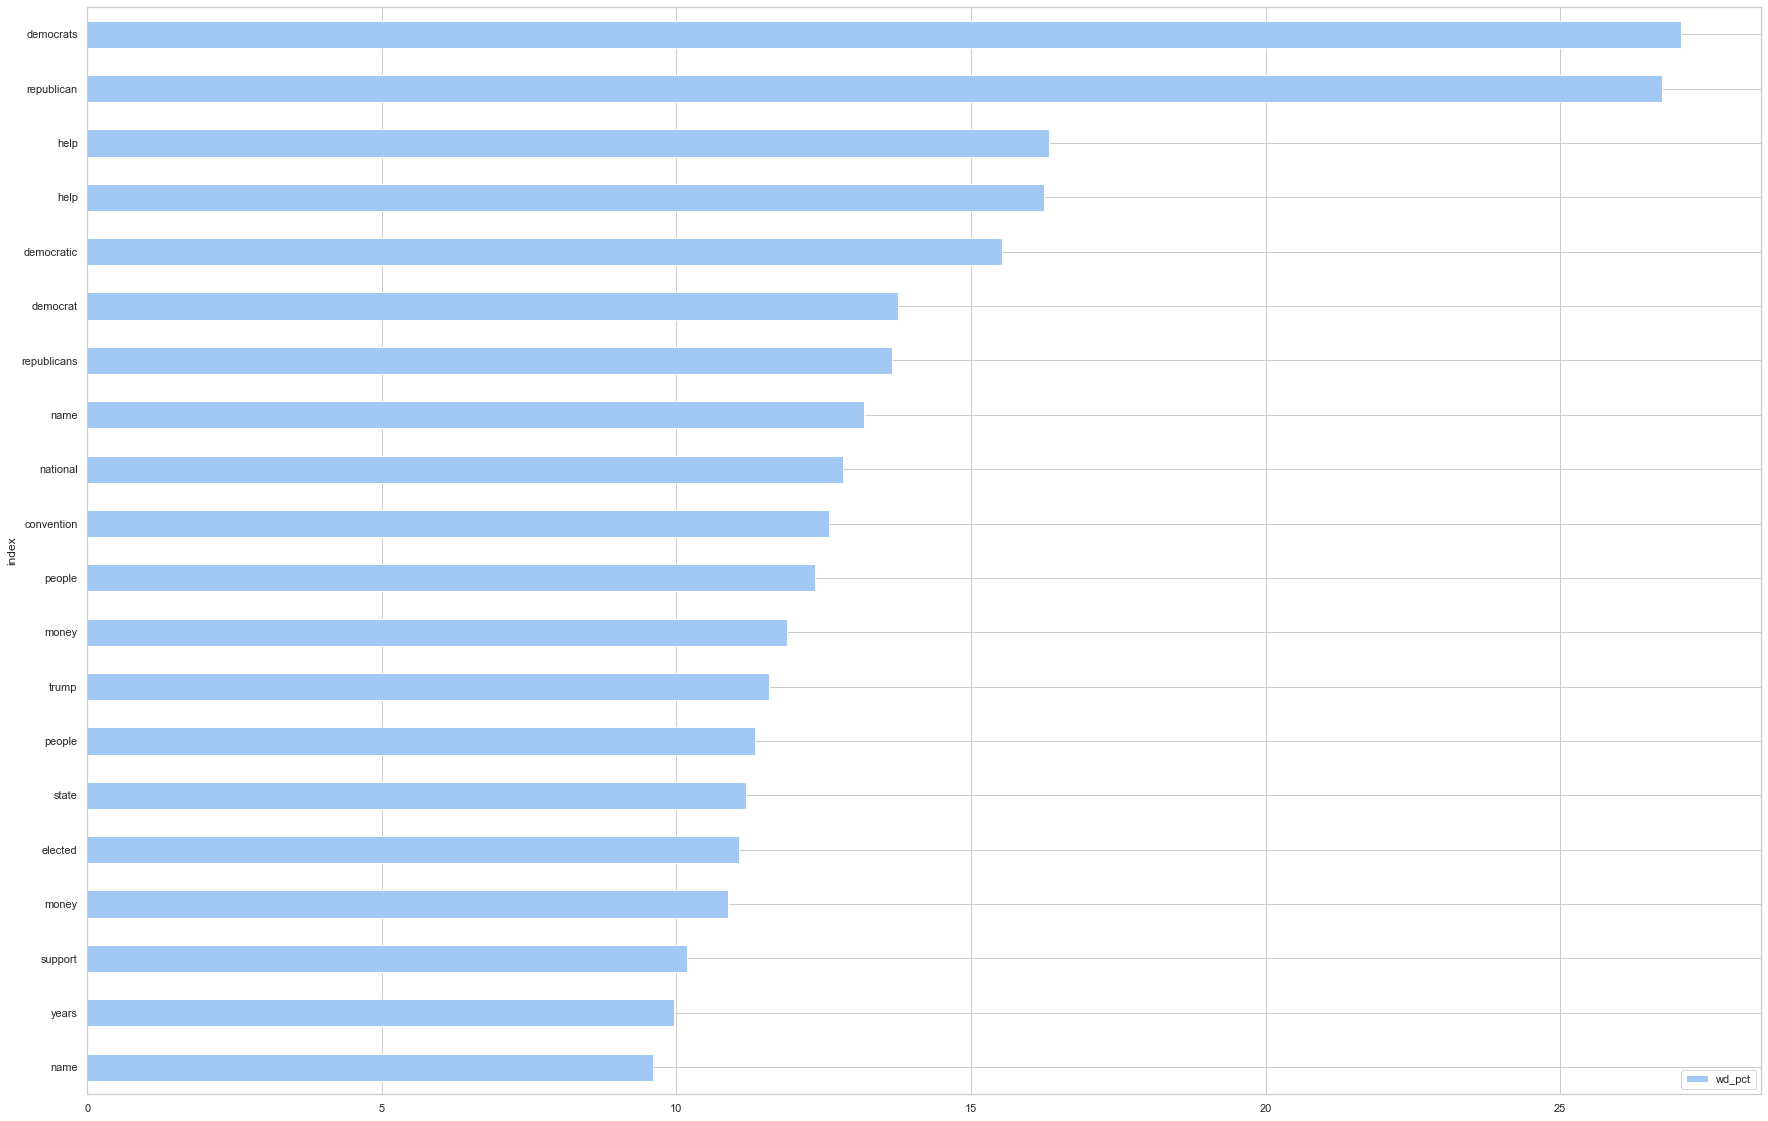

In [163]:
words_df.sort_values(by='wd_pct',ascending=False).head(20).sort_values(by='wd_pct',ascending=True).plot(x='index',y='wd_pct',kind='barh',figsize=(30,20))

In [164]:
ser_df=rslt
ser_df=ser_df.rename(columns={'Frequency':'total'})


In [165]:
ser_df=ser_df.reset_index()

In [166]:
words_df.head(3)

level_0        index  Word     wd_pct  tag
3        3   republican   231  26.736111  rep
6        6         help   141  16.319444  rep
8        8  republicans   118  13.657407  rep

In [167]:
words_df=words_df.merge(ser_df,left_on='index',right_on='Word',how='left')
words_df.head()

level_0        index  Word_x     wd_pct  tag       Word_y  total
0        3   republican     231  26.736111  rep   republican  334.0
1        6         help     141  16.319444  rep         help  328.0
2        8  republicans     118  13.657407  rep  republicans  159.0
3       12        trump     100  11.574074  rep        trump  240.0
4       13       people      98  11.342593  rep       people  241.0

In [168]:
ser_df[ser_df['Word']=='republican']

Word  total
6  republican    334

In [169]:
rslt=rslt.reset_index()
rslt[rslt['Word']=='republican']

Word  Frequency
6  republican        334

In [170]:
wrep=words_df[words_df.tag=='rep']
wdem=words_df[words_df.tag=='dem']

In [171]:
wrep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5859 entries, 0 to 5858
Data columns (total 7 columns):
level_0    5859 non-null int64
index      5859 non-null object
Word_x     5859 non-null int64
wd_pct     5859 non-null float64
tag        5859 non-null object
Word_y     459 non-null object
total      459 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 366.2+ KB


In [172]:
wdem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5679 entries, 5859 to 11537
Data columns (total 7 columns):
level_0    5679 non-null int64
index      5679 non-null object
Word_x     5679 non-null int64
wd_pct     5679 non-null float64
tag        5679 non-null object
Word_y     459 non-null object
total      459 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 354.9+ KB


In [173]:
onlyrep = list(set(wrep['index'].values)-set(wdem['index'].values))

In [174]:
onlydem =list(set(wdem['index'].values)-set(wrep['index'].values))

In [175]:
[*onlyrep,*onlydem]

['whit',
 'culminating',
 'filing',
 'criticized',
 'safari',
 'gatton',
 'polygraph',
 'sculptural',
 'bryan',
 'gaylord',
 'jene',
 'isolated',
 'alumnae',
 'sommers',
 'coffey',
 'dissertation',
 'mileage',
 'née',
 'overwhelming',
 'flooring',
 'sellout',
 'stagnation',
 'ale',
 'greensboro',
 'bizarre',
 'sl',
 'brethen',
 'appointment',
 'exorbitant',
 'richmond',
 'voiced',
 'virginians',
 'clothing',
 'expanded',
 'tps',
 'mathis',
 'patriotism',
 'poc',
 'piss',
 'crash',
 'gillum',
 'blighted',
 'shareable',
 'opted',
 'ball',
 'melania',
 'pains',
 'polish',
 'mailings',
 'terrell',
 'slowly',
 'longed',
 'whomever',
 'insuring',
 'descendants',
 'somehow',
 'doctorate',
 'whig',
 'crosswalk',
 'japan',
 'dodgeball',
 'ratification',
 'colors',
 'ukraine',
 'surveillance',
 'politicized',
 'fairgrounds',
 'cabin',
 'semanal',
 'patterns',
 'ee',
 'volunt',
 'marr',
 'sandra',
 'similar',
 'comedian',
 'homeland',
 'alba',
 'visual',
 'islamic',
 'rothschild',
 'purch',
 'nat

In [176]:
ucomw = words_df[words_df['index'].isin([*onlyrep,*onlydem])]

In [177]:
comw = wrep.merge(wdem, on="Word_y", how='inner',suffixes=('_rep','_dem'))

In [178]:
ucomw = wrep.merge(wdem, on="Word_y", how='outer',suffixes=('_rep','_dem'))

In [185]:
ucomw['wd_pct_demp']=-ucomw['wd_pct_dem']

In [186]:
ucomw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28188459 entries, 0 to 28188458
Data columns (total 14 columns):
level_0_rep    int64
index_rep      object
Word_x_rep     int64
wd_pct_rep     float64
tag_rep        object
Word_y         object
total_rep      float64
level_0_dem    int64
index_dem      object
Word_x_dem     int64
wd_pct_dem     float64
tag_dem        object
total_dem      float64
wd_pct_demp    float64
dtypes: float64(5), int64(4), object(5)
memory usage: 3.2+ GB


In [187]:
ucomw[pd.isnull(ucomw).any(axis=1)].sort_values(by='Word_x_dem',ascending=False).head(5)

level_0_rep  index_rep  Word_x_rep  wd_pct_rep tag_rep Word_y  \
331              368       meet          11    1.273148     rep    NaN   
9417211         2426  principle           2    0.231481     rep    NaN   
9375451         2417   stations           2    0.231481     rep    NaN   
9380671         2418  ignorance           2    0.231481     rep    NaN   
9385891         2419   spectrum           2    0.231481     rep    NaN   

         total_rep  level_0_dem index_dem  Word_x_dem  wd_pct_dem tag_dem  \
331            NaN          248   pledged          15    1.764706     dem   
9417211        NaN          248   pledged          15    1.764706     dem   
9375451        NaN          248   pledged          15    1.764706     dem   
9380671        NaN          248   pledged          15    1.764706     dem   
9385891        NaN          248   pledged          15    1.764706     dem   

         total_dem  wd_pct_demp  
331            NaN    -1.764706  
9417211        NaN    -1.764706  
9375451        NaN    -1.764706  
9380671        NaN    -1.764706  
9385891        NaN    -1.764706

In [188]:
plotting=ucomw.sort_values(by='total_dem',ascending=False).head(50)

In [189]:
plotting

level_0_rep    index_rep  Word_x_rep  wd_pct_rep tag_rep       Word_y  \
0              3   republican         231   26.736111     rep   republican   
1              6         help         141   16.319444     rep         help   
43            58    democrats          42    4.861111     rep    democrats   
4             13       people          98   11.342593     rep       people   
3             12        trump         100   11.574074     rep        trump   
5             14        money          94   10.879630     rep        money   
32            45   democratic          48    5.555556     rep   democratic   
10            19        state          78    9.027778     rep        state   
8             17         name          83    9.606481     rep         name   
27            39     national          53    6.134259     rep     national   
13            23        party          74    8.564815     rep        party   
68            85   convention          32    3.703704     rep   convention   
6             15      support          88   10.185185     rep      support   
46            61     democrat          41    4.745370     rep     democrat   
9             18         need          79    9.143519     rep         need   
12            21          get          75    8.680556     rep          get   
16            27    president          69    7.986111     rep    president   
2              8  republicans         118   13.657407     rep  republicans   
7             16        years          86    9.953704     rep        years   
41            56      elected          43    4.976852     rep      elected   
19            31           us          62    7.175926     rep           us   
11            20         time          76    8.796296     rep         time   
14            24     campaign          73    8.449074     rep     campaign   
29            42      america          51    5.902778     rep      america   
18            29         want          64    7.407407     rep         want   
20            32          one          60    6.944444     rep          one   
37            52       county          45    5.208333     rep       county   
15            26    political          71    8.217593     rep    political   
25            37      country          54    6.250000     rep      country   
63            79        young          34    3.935185     rep        young   
22            34        would          56    6.481481     rep        would   
17            28         like          65    7.523148     rep         like   
26            38          new          54    6.250000     rep          new   
31            44       school          49    5.671296     rep       school   
28            40         year          51    5.902778     rep         year   
24            36         make          55    6.365741     rep         make   
23            35       family          55    6.365741     rep       family   
38            53     election          45    5.208333     rep     election   
21            33         many          58    6.712963     rep         many   
33            46     american          48    5.555556     rep     american   
128          153     delegate          21    2.430556     rep     delegate   
62            78     district          34    3.935185     rep     district   
47            62        first          41    4.745370     rep        first   
58            74         vote          35    4.050926     rep         vote   
240          269       bernie          14    1.620370     rep       bernie   
30            43      college          49    5.671296     rep      college   
45            60         know          41    4.745370     rep         know   
34            47           go          47    5.439815     rep           go   
36            49       please          46    5.324074     rep       please   
44            59        raise          41    4.745370     rep        raise   

     total_rep  level_0_de

In [190]:
[abs(i) for i in list(np.arange(-30, 31, step=5))]

[30, 25, 20, 15, 10, 5, 0, 5, 10, 15, 20, 25, 30]

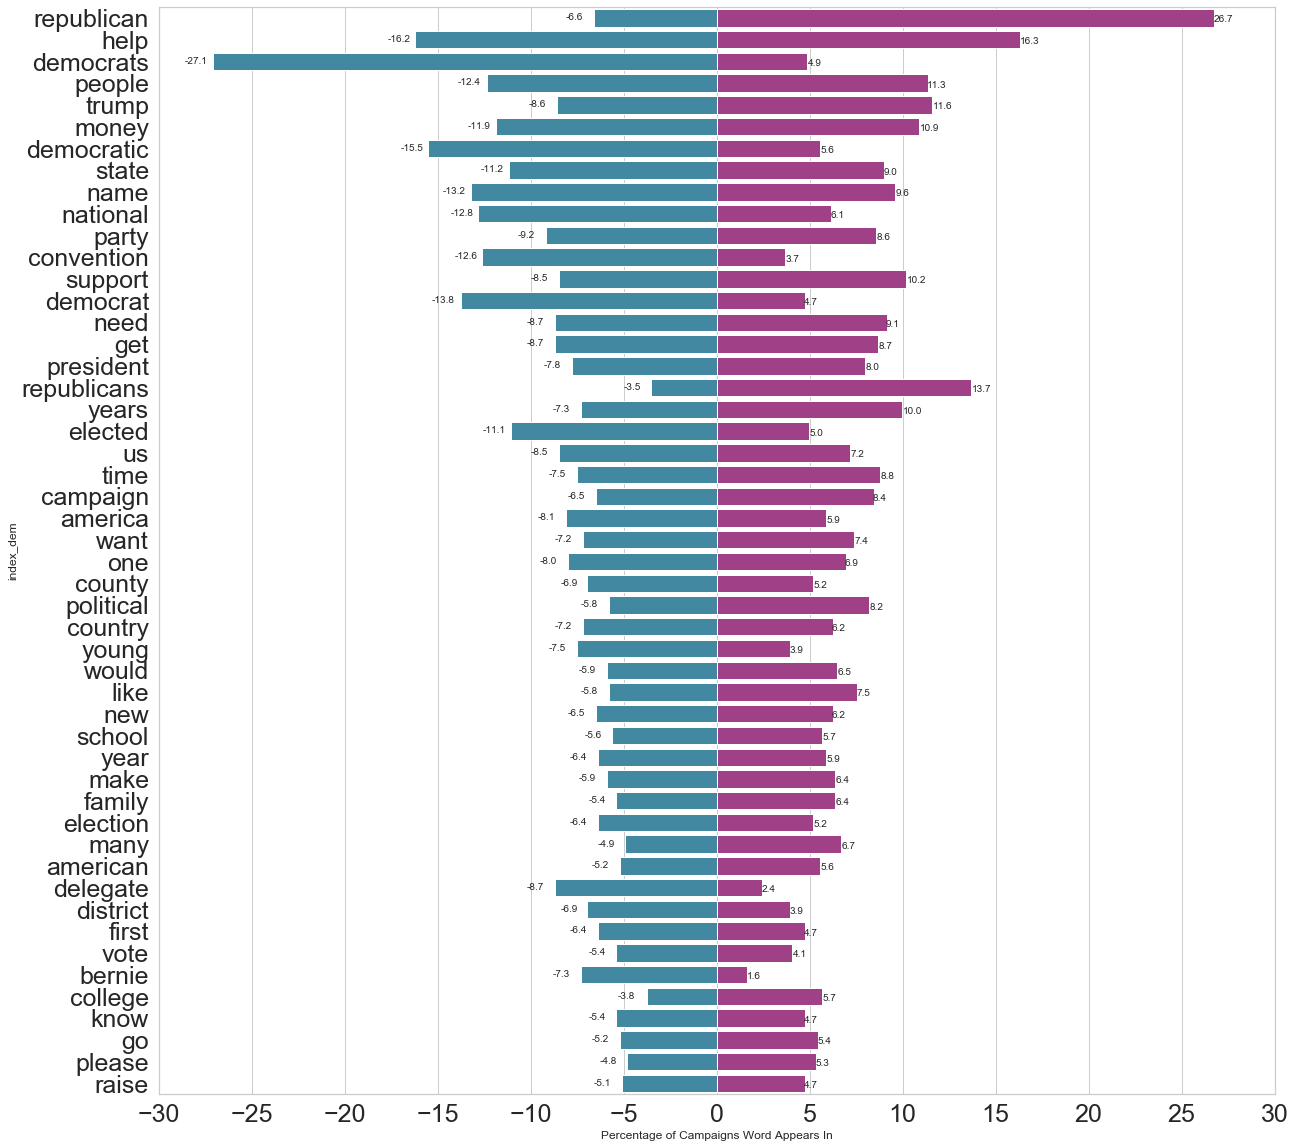

In [204]:
rcParams['figure.figsize'] = 20, 20

sns.set_style("whitegrid")
sns.set_color_codes("pastel")

bar_plot = sns.barplot(x = 'wd_pct_rep', y = "index_rep", color='#B03190',data = plotting)
bar_plot = sns.barplot(x = 'wd_pct_demp', y = "index_dem", color='#3190B0',data = plotting)
plt.xticks(np.arange(-30, 31, step=5))

# a=[abs(i) for i in list(np.arange(-30, 31, step=5))]
# bar_plot.set_xticklabels(a)

for i, v in enumerate(plotting['wd_pct_rep'].apply(lambda x: round(x, 1)).reset_index(drop=True)):
    bar_plot.text(v+0.005, i+0.2, str(v))
for i, v in enumerate(plotting['wd_pct_demp'].apply(lambda x: round(x, 1)).reset_index(drop=True)):
    bar_plot.text(v-1.5, i+0.1, str(v))

bar_plot.set(xlabel="Percentage of Campaigns Word Appears In")
plt.tick_params(labelsize=25)
plt.savefig("gofundmecampaigns.pdf")

In [106]:
comw['Word_x_demp']=-comw['Word_x_dem']

In [107]:
comw.head()

level_0_rep    index_rep  Word_x_rep  wd_pct_rep tag_rep       Word_y  \
0            3   republican         231    0.267361     rep   republican   
1            6         help         141    0.163194     rep         help   
2            9  republicans         118    0.136574     rep  republicans   
3           12        trump         100    0.115741     rep        trump   
4           13       people          98    0.113426     rep       people   

   total_rep  level_0_dem    index_dem  Word_x_dem  wd_pct_dem tag_dem  \
0      334.0           40   republican          56    0.065882     dem   
1      328.0            6         help         138    0.162353     dem   
2      159.0          100  republicans          30    0.035294     dem   
3      240.0           24        trump          73    0.085882     dem   
4      241.0           15       people         105    0.123529     dem   

   total_dem  Word_x_demp  
0      334.0          -56  
1      328.0         -138  
2      159.0          -30  
3      240.0          -73  
4      241.0         -105

[Text(0, 0.5, 'word'), Text(0.5, 0, 'frequency'), Text(0.5, 1.0, 'Pyramid')]

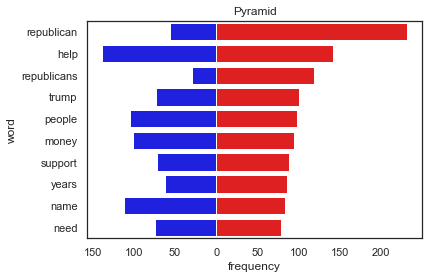

In [113]:
sns.set_style("white")
#sns.set_color_codes("pastel")
bar_plot = sns.barplot(x = 'Word_x_rep', y = "index_rep", color = "red", data = comw.head(10))
bar_plot = sns.barplot(x = 'Word_x_demp', y = "index_dem", color = "blue", data = comw.head(10))
# sns is seaborn alias
a=[200, 150, 100, 50, 0, 50, 100, 150, 200, 250]
bar_plot.set_xticklabels(a)
bar_plot.set(xlabel="frequency", ylabel="word", title = "Pyramid")



[-200.0, -150.0, -100.0, -50.0, 0.0, 50.0, 100.0, 150.0, 200.0, 250.0]

In [63]:
words_df[words_df['index']=='republican']

level_0       index  Word_x    wd_pct  tag      Word_y  total
0           3  republican     231  0.267361  rep  republican  334.0
5888       40  republican      56  0.065882  dem  republican  334.0

In [33]:
ser=words_df.total

In [40]:
words_df['word_bin']=pd.qcut(ser, q=5,labels=['1','2','3','4','5'])

# sns.catplot(kind='bar',x='Frequency',y='Word',hue='tag',row='word_bin',data=words_df,height=20,aspect=2)

In [51]:
#making individual bins because 
words_df_3=words_df[words_df['word_bin']=='3']
words_df_1=words_df[words_df['word_bin']=='1']
words_df_2=words_df[words_df['word_bin']=='2']
words_df_4=words_df[words_df['word_bin']=='4']
words_df_5=words_df[words_df['word_bin']=='5']

In [42]:
words_df_3.Word.unique()

array(['nonetype', 'congress', 'start', '”', 'right', 'raised',
       'presidential', 'story', 'left', 'come', 'governor', 'club', 'ago',
       '#', 'small', 'way', 'long', 'change', 'together', 'week', 'keep',
       'used', 'good', 'group', 'care', 'education', 'city', 'show',
       'media', 'important', 'former', 'around', 'build', 'trying',
       'must', 'law', 'issues', 'fellow', 'bring', 'november', 'friend',
       'continue', 'dear', 'read', '5', 'helping', 'today', 'june',
       'future', 'past', 'voters', 'still', 'part', 'little', 'put',
       'news', 'become', 'cover', 'travel', 'funding', 'lives', 'strong',
       'member', '4', 'ca', 'voting', 'nation', 'page', 'march',
       'facebook', 'liberal', 'ever', 'lost', 'expenses', 'senator',
       'hard', 'away', 'provide', 'getting', 'world', 'send', 'cost',
       'delegates', 'hillary', 'dnc', 'progressive', 'honor', 'upcoming',
       'san'], dtype=object)

In [52]:
words_df_5.Word.unique()

array([',', '.', '...', '!', 'republican', "'s", '’', ':', 'help', '(',
       ')', 'trump', 'republicans', 'people', 'money', 'support', 'state',
       'years', 'party', '``', 'name', "''", 'campaign', "'m", 'need',
       'political', 'time', 'president', 'get', 'want', 'family', 'like',
       'would', 'us', '-', '?', 'one', 'many', 'new', 'america',
       'national', 'year', 'college', 'make', 'country', 'county', '$',
       '--', 'school', 'conservative', 'american', 'states', 'democratic',
       'united', 'election', 'please', 'first', 'democrat', 'life', 'go',
       'know', 'running', 'elected', 'great', 'democrats', 'vote', "n't",
       'community', 'raise', 'hello', 'funds', 'hi', 'convention',
       'raising', 'district', 'friends', 'work', 'since', 'young', 'fund',
       'house', 'high', 'delegate', '2016', 'bernie', 'sanders'],
      dtype=object)

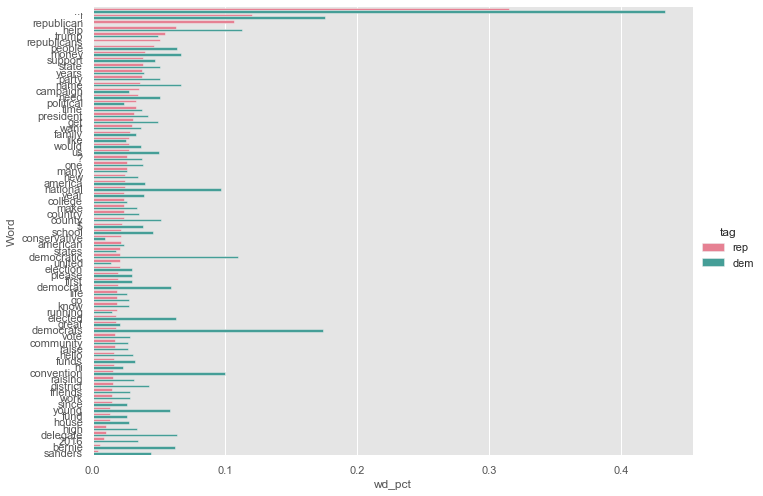

In [54]:
sns.catplot(y="Word", x="wd_pct", hue="tag", kind="bar", 
            data=words_df_5[words_df_5.Word.isin([',', '.',"'s", '’', ':','(',')',"'m","''",'``','“',"'ve",';','(',')',"n't",'--','-'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

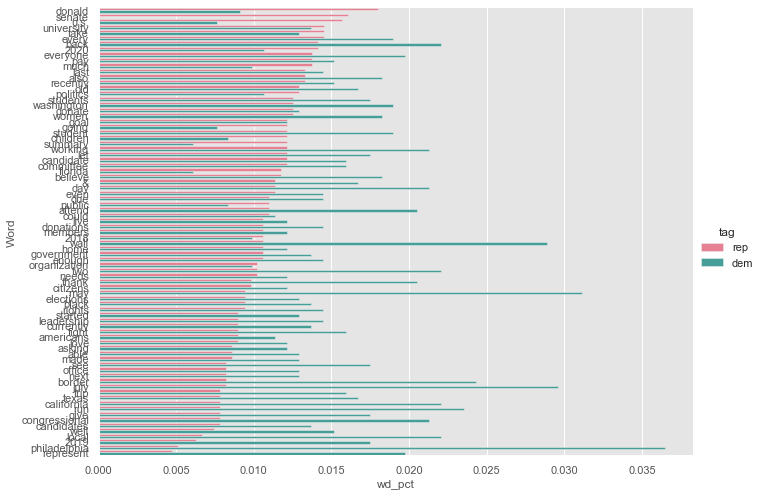

In [50]:
sns.catplot(y="Word", x="wd_pct", hue="tag", kind="bar", 
            data=words_df_4[words_df_4.Word.isin([',', '.',"'s", '’', ':','(',')',"'m","''",'``','“',"'ve",';'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

In [182]:
ser 